# Segment Anything by Meta

**Author:** Burak Dogan  
**Contact:** ab0971@student.jamk.fi

Following code snippets and some of the technical explanations are taken from Segment Anything Git Hub repo and demo notebooks. Tailored the the need of the project.
  

[Segment Anything repo](https://github.com/facebookresearch/segment-anything)

Segment Anything model is used for masking and cropping the images.

Depending on the need there are three possible models to use

1. Vit-H (Huge) : Largest and most complex
2. Vit-L (Large): Smaller than large model and less complex 
3. Vit-B (Base) : Base model, least complex and smaller than the rest

Use of Vit-B will be enough for this project.

### Enviroment Setup

Using Anaconda.

Created new environment just for SAM model.

To install correct version and compute platform (GPU or CPU) of Pytorch, visit [Pytorch](https://pytorch.org/get-started/locally/#anaconda)

Currently using:
- Build: Pytorch 2.3.0
- Windows OS
- Package: Conda
- Language: Python
- Compute Platform: CUDA 11.8

Need to update the CUDA version on the computer if necessary (currently 12.7.33)

Command to use for this environment : `conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`

Other dependencies to install:

Also the model can be installed through conda [here](https://anaconda.org/conda-forge/segment-anything) or repo can be cloned from Github.

- `conda install conda-forge::segment-anything`
- `conda install numpy`
- `conda install matplotlib`
- `conda install -c conda-forge opencv` - Open CV is used for visualizing the images if needed.
  

Segment Anything GitHub repo has pre-trained model checkpoints. 
  
[Vit-B model checkpoint](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth) is used in this project. But depending on the need others can be used.





## Libraries for SAM Algorithm

In [1]:
import os
import gc
import cv2
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

### Rename Files

Removing unnecessary parts from the image files to make it easier to read and access.  

Running the next cell, will remove the **_DSC** , **leading zeros** and adds **Log_ID** in front of the name.  

Supply the ID and file names manually. 

In [2]:
# Assign image_folder variable with 'path/to/folder' containing the image files
image_folder = 'Reruns/extras'

# Example dictionary mapping filenames to IDs (without _DSC and leading zeros)
# Filenames will be converted to ID-filename format
# Format: {'old_filename': 'ID'}
file_id_mapping = {
    '718': 'P241',
    '719': 'P241',
    '720': 'P241',
    '721': 'P241',
    '722': 'P241',
    '723': 'P241',
    '724': 'Pnocode',
    '725': 'Pnocode',
    '726': 'Pnocode',
    '727': 'Pnocode',
    '728': 'Pnocode',
    '729': 'Pnocode',
    '730': 'P250',
    '731': 'P250',
    '732': 'P250',
    '733': 'P250',
    '734': 'P250',
    '735': 'P250',
    '736': 'P245',
    '737': 'P245',
    '738': 'P245',
    '739': 'P245',
    '740': 'P245',
    '741': 'P245',
    '742': 'P249',
    '743': 'P249',
    '744': 'P249',
    '745': 'P249',
    '746': 'P249',
    '747': 'P249',
    '748': 'S250',
    '749': 'S250',
    '750': 'S250',
    '751': 'S250',
    '752': 'S250',
    '753': 'S250',
    '754': 'S243',
    '755': 'S243',
    '756': 'S243',
    '757': 'S243',
    '758': 'S243',
    '759': 'S243',
    '760': 'S242',
    '761': 'S242',
    '762': 'S242',
    '763': 'S242',
    '764': 'S242',
    '765': 'S242',
    '766': 'S249',
    '767': 'S249',
    '768': 'S249',
    '769': 'S249',
    '770': 'S249',
    '771': 'S249',
    '772': 'S246',
    '773': 'S246',
    '774': 'S246',
    '775': 'S246',
    '776': 'S246',
    '777': 'S246'
    
}

# Iterate through each file in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.JPG') or filename.endswith('.jpg'):  # Ensure it's a JPG file
        # Extract the number part of the filename
        number_part = filename.split('_DSC')[1].split('.')[0]  # Extract XXXX from _DSCXXXX.JPG
        
        # Remove leading zeros
        number_part = str(int(number_part))
        
        # Get the corresponding ID from the dictionary
        if number_part in file_id_mapping:
            ID = file_id_mapping[number_part]
            
            # Construct the new filename with the ID prefix
            new_filename = f"{ID}-{number_part}.JPG"
            
            # Construct the old and new file paths
            old_file_path = os.path.join(image_folder, filename)
            new_file_path = os.path.join(image_folder, new_filename)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed {filename} to {new_filename}")
        else:
            print(f"No ID found for {number_part}, skipping...")

Renamed _DSC0718.JPG to P241-718.JPG
Renamed _DSC0719.JPG to P241-719.JPG
Renamed _DSC0720.JPG to P241-720.JPG
Renamed _DSC0721.JPG to P241-721.JPG
Renamed _DSC0722.JPG to P241-722.JPG
Renamed _DSC0723.JPG to P241-723.JPG
Renamed _DSC0724.JPG to Pnocode-724.JPG
Renamed _DSC0725.JPG to Pnocode-725.JPG
Renamed _DSC0726.JPG to Pnocode-726.JPG
Renamed _DSC0727.JPG to Pnocode-727.JPG
Renamed _DSC0728.JPG to Pnocode-728.JPG
Renamed _DSC0729.JPG to Pnocode-729.JPG
Renamed _DSC0730.JPG to P250-730.JPG
Renamed _DSC0731.JPG to P250-731.JPG
Renamed _DSC0732.JPG to P250-732.JPG
Renamed _DSC0733.JPG to P250-733.JPG
Renamed _DSC0734.JPG to P250-734.JPG
Renamed _DSC0735.JPG to P250-735.JPG
Renamed _DSC0736.JPG to P245-736.JPG
Renamed _DSC0737.JPG to P245-737.JPG
Renamed _DSC0738.JPG to P245-738.JPG
Renamed _DSC0739.JPG to P245-739.JPG
Renamed _DSC0740.JPG to P245-740.JPG
Renamed _DSC0741.JPG to P245-741.JPG
Renamed _DSC0742.JPG to P249-742.JPG
Renamed _DSC0743.JPG to P249-743.JPG
Renamed _DSC0744.JPG

## Prepare Model

Taken from [Git Hub repo](https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py)

Arguments:
* **model (Sam):** The SAM model to use for mask prediction.
  
* **points_per_side (int or None):** The number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, 'point_grids' must provide explicit point sampling.
  
* **points_per_batch (int):** Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.
  
* **pred_iou_thresh (float):** A filtering threshold in [0,1], using the model's predicted mask quality.
  
* **stability_score_thresh (float):** A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.
  
* **stability_score_offset (float):** The amount to shift the cutoff when calculated the stability score.
  
* **box_nms_thresh (float):** The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
  
* **crop_n_layers (int):** If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
  
* **crop_nms_thresh (float):** The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.  

* **crop_overlap_ratio (float):** Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.  
  
* **crop_n_points_downscale_factor (int):** The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.  

* **point_grids (list(np.ndarray) or None):** A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.  
  
* **min_mask_region_area (int):** If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.  

* **output_mode (str):** The form masks are returned in. Can be 'binary_mask', 'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools. For large resolutions, 'binary_mask' may consume large amounts of memory.  

### Crop and Export Masks

Largest mask is not consistent. Sometimes the background is the largest, or the object. So supervision is necessary. Top two largest areas are saved into dataframe and exported as CSV.  

Dataframe has two columns:
* ID
* area

In [3]:
import os
import gc
import cv2
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Add the path and import SAM modules
sys.path.append("..")

# Define parameters
#sam_checkpoint = "sam_vit_h_4b8939.pth" # Huge model checkpoint
#sam_checkpoint = "sam_vit_l_0b3195.pth" # Large model checkpoint
sam_checkpoint = "sam_vit_b_01ec64.pth" # Base model checkpoint
#model_type = "vit_h" # Huge model type
#model_type = "vit_l" # Large model type
model_type = "vit_b" # Base model type
device = "cuda"

# Load the SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Initialize the mask generator with adjusted parameters
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_batch=14, # Higher values can cause memory issue. Adjust according to VRAM 
    points_per_side=32,
    pred_iou_thresh=0.86, # 0.86
    stability_score_thresh=0.95, # default 0.95
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10000  # Focus on large objects?
)

"""

!! !! DO NOT FORGET TO CHANGE root_dir and folder_names list to target folder !! !! 

"""

# Define the root directory containing all folders
root_dir = 'ends_rerun/pine'

# List of folder names to process
folder_names = ['Site 1']

"""

!! !! DO NOT FORGET TO CHANGE OUTPUT DIRECTORY !! !! 

"""

# Define the output directory
output_root_dir = 'ends_rerun\cropped_images\cropped\pine'

os.makedirs(output_root_dir, exist_ok=True)

# Initialize a list to store mask data
mask_data = []

# Function to print messages with timestamps
def print_with_timestamp(message):
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"[{timestamp}] {message}")

# Process each folder
for folder_name in folder_names:
    input_dir = os.path.join(root_dir, folder_name)
    output_dir = os.path.join(output_root_dir, folder_name)
    os.makedirs(output_dir, exist_ok=True)
    image_files = os.listdir(input_dir)

    print_with_timestamp(f"Total number of images to process in {folder_name}: {len(image_files)}")

    # Iterate through each image in the input directory
    for idx, filename in enumerate(image_files):
        print_with_timestamp(f"Processing image {idx + 1}/{len(image_files)} in {folder_name}: {filename}")

        image_path = os.path.join(input_dir, filename)

        # Load and preprocess the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Generate masks
        masks = mask_generator.generate(image_rgb)

        # Sort masks by area in descending order
        sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

        # Process the top 2 largest masks
        for i in range(len(sorted_masks)):
            mask_info = sorted_masks[i]

            # Extract details of the mask
            mask = mask_info['segmentation']
            bbox = mask_info['bbox']
            area = mask_info['area']

            # Prepare filenames for output images
            base_filename, ext = os.path.splitext(filename)
            masked_output_path = os.path.join(output_dir, f'{base_filename}_masked_{i+1}{ext}')
            #cropped_output_path = os.path.join(output_dir, f'{base_filename}_cropped_{i+1}{ext}') # Decresing clutter of exports
            transparent_output_path = os.path.join(output_dir, f'{base_filename}_transparent_{i+1}.png')

            # Append mask information to the dataframe
            mask_data.append({
                'ID': f'{base_filename}_cropped_{i+1}{ext}',
                'area': area,
                'top_left_x': bbox[0],
                'top_left_y': bbox[1]
            })

            # Apply mask to the image
            masked_image = image_rgb.copy()
            masked_image[mask == 0] = 0  # Black out the areas not in the mask

            # Save the masked output image (image with mask applied)
            masked_image_bgr = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(masked_output_path, masked_image_bgr)

            # Ensure bounding box coordinates are integers
            x, y, w, h = map(int, bbox)

            # Crop the image using the mask's bounding box
            cropped_image = masked_image[y:y+h, x:x+w]
            cropped_image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
            #cv2.imwrite(cropped_output_path, cropped_image_bgr)

            # Create a transparent image using PIL
            image_pil = Image.fromarray(image_rgb)
            mask_pil = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")

            # Create an RGBA image with transparency
            transparent_image_pil = Image.new("RGBA", image_pil.size)
            transparent_image_pil.paste(image_pil, (0, 0), mask_pil)

            # Crop the transparent image
            transparent_cropped = transparent_image_pil.crop((x, y, x + w, y + h))

            # Save the transparent image
            transparent_cropped.save(transparent_output_path)

        print_with_timestamp(f"Completed processing image: {filename}")

        # Clear GPU memory and run garbage collection after processing each image
        del masks
        del sorted_masks
        torch.cuda.empty_cache()
        gc.collect()

# Convert mask data to a pandas dataframe
df_new = pd.DataFrame(mask_data)

# Define the path to the CSV file in the current working directory
csv_output_path = os.path.join(os.getcwd(), 'mask_areas.csv')

# Check if the CSV file exists and append new data
if os.path.exists(csv_output_path):
    df_existing = pd.read_csv(csv_output_path)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.to_csv(csv_output_path, index=False)
else:
    df_new.to_csv(csv_output_path, index=False)

# Clear GPU memory at the end of run
torch.cuda.empty_cache()
gc.collect()

print_with_timestamp("All images have been processed and results have been saved.")

[14:27:50] Total number of images to process in Site 1: 1
[14:27:50] Processing image 1/1 in Site 1: P121-40.JPG
[14:31:35] Completed processing image: P121-40.JPG
[14:31:36] All images have been processed and results have been saved.


In [ ]:
del masks
del sorted_masks
torch.cuda.empty_cache()
gc.collect()

# Data Clean Up and Data Set Build

## Drop Lines Containing Zero and Clean "ID" column

In [4]:
import pandas as pd

# Read the CSV file
csv_file = "mask_areas.csv"  # Replace with your CSV file path
df = pd.read_csv(csv_file)

#  Count the initial number of rows
initial_row_count = len(df)
print(f"Initial number of rows: {initial_row_count}")

# Find rows that contain zero in any column
rows_with_zero = df[(df == 0).any(axis=1)]
print(f"Total count of rows contain zero {len(rows_with_zero)}")

# Print the content of rows to be removed
#print("Rows to be removed (contain zero):")
#for index, row in rows_with_zero.iterrows():
#    print(f"Row{index}:")
#    print(row)

# Drop rows that contain zero
df = df[(df != 0).all(axis=1)]

# Count the final number of rows
final_row_count = len(df)
print(f"Final number of rows: {final_row_count}")

# Save the updated CSV (without removed rows)
df.to_csv("mask_areas_no_zero.csv", index=False)  # Update this with your desired output file name

Initial number of rows: 90248
Total count of rows contain zero 18826
Final number of rows: 71422


In [25]:
import os
import pandas as pd

# Load the original CSV file
original_csv_path = 'mask_areas_no_zero.csv'
df = pd.read_csv(original_csv_path)

# Create a new DataFrame to avoid modifying the original one
new_df = df.copy()

# Modify the 'ID' column, replacing 'cropped' with 'transparent' and 'JPG' with 'png'
new_df['ID'] = new_df['ID'].str.replace('JPG', 'png')

# Define the path to save the new CSV file
new_csv_path = 'mask_areasIDmod.csv'

# Save the modified DataFrame to a new CSV file
new_df.to_csv(new_csv_path, index=False)

print("New dataset has been created and saved successfully.")

New dataset has been created and saved successfully.


## Pine Data Set Build

There are duplicates and wrongly named files due to running images with different model sizes. In some cases Background and log mask named similar. This led to inaccurate cleaning of the data.

First approach to clean the data as follows:

1) Iterate through each image folder
2) Cross check with the mask_area.csv
3) If image name and **ID** in mask_area.csv matches save the row to new dataframe
4) Export dataframe


In [26]:
# Load the ID modified data set into dataframe
csv_path = 'mask_areasIDmod.csv'
IDmod_df = pd.read_csv(csv_path)

# New dataframe to store matched rows
matched_df = pd.DataFrame(columns=IDmod_df.columns)

# Define path to folders to be iterated
main_folder = 'pine_sites'

# Iterate through each subfolder in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    # Path to images
    image_folder_path = os.path.join(subfolder_path, 'cropped')

    # Checl if the folder exists
    if os.path.isdir(image_folder_path):
        # Iterate through each image in 'cropped'
        for image_file in os.listdir(image_folder_path):
            # Compare full file name with 'ID' column of mask_areas_IDmod.csv
            matching_rows = IDmod_df[IDmod_df['ID'].str.contains(image_file, case=False, na=False)]

            if not matching_rows.empty:
                matched_df = pd.concat([matched_df, matching_rows])
print(len(matched_df))
# Export the matched dataframe to new CSV file
output_csv_path = 'mask_area_modified_pine.csv'
matched_df.to_csv(output_csv_path, index=False)

print(f"Matched data has been saved to {output_csv_path}")
            

C:\Users\olurt\AppData\Local\Temp\ipykernel_13140\2975935743.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  matched_df = pd.concat([matched_df, matching_rows])


1524
Matched data has been saved to mask_area_modified_pine.csv


In [27]:
# Clean the ID column. Remove unnecessary indicators that came from SAM output.

# Load CSV from previous step to clean ID column's rows.
csv_path = 'mask_area_modified_pine.csv'
df = pd.read_csv(csv_path)

# Remove characters after '_' in the ID column
df['ID'] = df['ID'].str.split('_').str[0]

# Save the modified dataframe to new CSV
output_csv_path = 'mask_area_modified_pine_ID_cleaned.csv'
df.to_csv(output_csv_path, index=False)

print(f"Modified CSV has been saved to {output_csv_path}")

Modified CSV has been saved to mask_area_modified_pine_ID_cleaned.csv


There seems to be some duplicate names and coordinates with zero values in the data set. Only the rows with no zero values are needed. Duplicates need further work.

In [29]:
# Load the CSV file
df = pd.read_csv('mask_area_modified_pine_ID_cleaned.csv')

# Find rows with zero values in the entire dataframe
zero_value_rows = df[(df == 0).any(axis=1)]

# Display the rows with zero values
print(zero_value_rows)

# Find duplicates in the 'Log_ID' column
#duplicates = df[df.duplicated(subset='ID', keep=False)]

# Display the duplicate rows
#print("\nDuplicate Rows Based on 'ID' Column:")
#print(duplicates)

# Optionally, save the duplicates to a new CSV file
#duplicates.to_csv('duplicate_area_pine.csv', index=False)

Empty DataFrame
Columns: [ID, area, top_left_x, top_left_y]
Index: []


## Pine Data Duplicate Rows

In [11]:
import pandas as pd

# Define the path to your CSV file
csv_file_path = 'pine_merged_dataset.csv'

# Read the CSV file into a DataFrame
df_pine = pd.read_csv(csv_file_path)
print(len(df_pine))

# Find and remove exact duplicate rows, keeping the first occurrence
df_unique_pine = df_pine.drop_duplicates(keep='first')
print(len(df_unique_pine))
#Check for duplicates (ID column)
id_column = 'ID'

# Find duplicate IDs
duplicate_ids = df_unique_pine[df_unique_pine[id_column].duplicated(keep=False)]

# Print the duplicates
print(f"Total number of duplicate rows in the '{id_column}' column: {len(duplicate_ids)}")
#print(duplicate_ids)
print(len(df_unique_pine))
print(len(duplicate_ids))
# Iterate through the duplicate IDs

#for index, row in duplicate_ids.iterrows():
#    print(f"\nShowing duplicate row {index}:")
#    print(row)

with open('pine_duplicates_2.txt', 'w') as f:
    for index, row in duplicate_ids.iterrows():
        f.write(f"\nShowing duplicate row {index}:\n")
        f.write(row.to_string())
        f.write("\n")

1442
1441
Total number of duplicate rows in the 'ID' column: 0
1441
0


## Spruce Data Set Build

In [30]:
import os
import pandas as pd

# Define the main directory containing all subfolders
main_folder = 'spruce_sites'

# Function to rename files in each 'cropped' folder
def rename_files_in_folder(folder_path):
    # The path to the 'cropped' folder inside the current subfolder
    cropped_folder_path = os.path.join(folder_path, 'cropped')
    
    if not os.path.exists(cropped_folder_path):
        print(f"No 'cropped' folder found in {folder_path}")
        return
    
    # Iterate through each file in the 'cropped' folder
    for filename in os.listdir(cropped_folder_path):
        # Check if 'transparent' is in the filename
        if 'transparent' in filename:
            # Create the new filename by replacing 'transparent' with 'cropped'
            new_filename = filename.replace('transparent', 'cropped')
            
            # Get the full paths for the old and new filenames
            old_file_path = os.path.join(cropped_folder_path, filename)
            new_file_path = os.path.join(cropped_folder_path, new_filename)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {filename} to {new_filename}")

# Iterate through all subfolders in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    
    # Check if it's a directory (subfolder)
    if os.path.isdir(subfolder_path):
        rename_files_in_folder(subfolder_path)

print("File renaming completed.")

File renaming completed.


In [31]:
# 'mask_areasIDmod.csv' file is created earlier under Pine Data Set Build section of this notebook.

# Load the ID modified data set into dataframe
csv_path = 'mask_areasIDmod.csv'
IDmod_df = pd.read_csv(csv_path)

# New dataframe to store matched rows
matched_df = pd.DataFrame(columns=IDmod_df.columns)

# Define path to folders to be iterated - spruce_sites
main_folder = 'spruce_sites'

# Iterate through each subfolder in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    # Path to images
    image_folder_path = os.path.join(subfolder_path, 'cropped')

    # Checl if the folder exists
    if os.path.isdir(image_folder_path):
        # Iterate through each image in 'cropped'
        for image_file in os.listdir(image_folder_path):
            # Compare full file name with 'ID' column of mask_areas_IDmod.csv
            matching_rows = IDmod_df[IDmod_df['ID'].str.contains(image_file, case=False, na=False)]

            if not matching_rows.empty:
                matched_df = pd.concat([matched_df, matching_rows])
print(len(matched_df))
# Export the matched dataframe to new CSV file
output_csv_path = 'mask_area_modified_spruce.csv'
matched_df.to_csv(output_csv_path, index=False)

print(f"Matched data has been saved to {output_csv_path}")

C:\Users\olurt\AppData\Local\Temp\ipykernel_13140\1655537683.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  matched_df = pd.concat([matched_df, matching_rows])


1548
Matched data has been saved to mask_area_modified_spruce.csv


In [32]:
# Clean the ID column. Remove unnecessary indicators that came from SAM output.

# Load CSV from previous step to clean ID column's rows.
csv_path = 'mask_area_modified_spruce.csv'
df = pd.read_csv(csv_path)

# Remove characters after '_' in the ID column
df['ID'] = df['ID'].str.split('_').str[0]

# Save the modified dataframe to new CSV
output_csv_path = 'mask_area_modified_spruce_ID_cleaned.csv'
df.to_csv(output_csv_path, index=False)

print(f"Modified CSV has been saved to {output_csv_path}")

Modified CSV has been saved to mask_area_modified_spruce_ID_cleaned.csv


## Spruce Data Duplicate Rows

In [27]:
import pandas as pd

# Define the path to your CSV file
csv_file_path = 'raw_data/mask_area_modified_spruce_ID_cleaned.csv'

# Read the CSV file into a DataFrame
df_spruce = pd.read_csv(csv_file_path)

# Find and remove exact duplicate rows, keeping the first occurrence
df_unique_spruce = df_spruce.drop_duplicates(keep='first')

#Check for duplicates (ID column)
id_column = 'ID'

# Find duplicate IDs
duplicate_ids = df_unique_spruce[df_unique_spruce[id_column].duplicated(keep=False)]

# Print the duplicates
print(f"Total number of duplicate rows in the '{id_column}' column: {len(duplicate_ids)}")
#print(duplicate_ids)

print(len(df_spruce))
print(len(df_unique_spruce))
print(len(duplicate_ids))

# Iterate through the duplicate IDs
#for index, row in duplicate_ids.iterrows():
#    print(f"\nShowing duplicate row {index}:")
#    print(row)

with open('spruce_duplicates.txt', 'w') as f:
    for index, row in duplicate_ids.iterrows():
        f.write(f"\nShowing duplicate row {index}:\n")
        f.write(row.to_string())
        f.write("\n")

Total number of duplicate rows in the 'ID' column: 207
1548
1449
207


## Remove Duplicate Rows - Pines

Using duplicate data set, found the rows that contain duplicate or wrong data. Took note of those rows and they will be removed in this step

In [9]:
import pandas as pd

# Load DataFrame
#df_pine = pd.read_csv("raw_data/mask_area_modified_pine_ID_cleaned.csv")
df_pine = pd.read_csv("cleaned_data/pine_merged_dataset.csv")

# Remove exact duplicates, keeping the first occurance
df_unique_pine = df_pine.drop_duplicates(keep='first')
print(len(df_unique_pine))
# Load row indices to be removed from a TXT file
with open('pine_wrong_rows.txt', 'r') as file:
    rows_to_remove_str = file.read()

# Convert the string of numbers into a list of integers
rows_to_remove = list(map(int, rows_to_remove_str.split(', ')))
print(len(rows_to_remove))
# Check if row indices are valid before removing
if max(rows_to_remove) < len(df_unique_pine):
    # Print the content of rows to be removed
    rows_content_to_remove = df_unique_pine.iloc[rows_to_remove]
    print("Rows to be removed:")
    print(rows_content_to_remove)

    # Print the content of rows to be removed one by one
    print("Rows to be removed (duplicate or wrong):")
    for index, row in rows_content_to_remove.iterrows():
        print(f"Row {index}:")
        print(row)
        print('-' * 50)  # Separator for readability

# Remove the rows using row index numbers
df_nodupe_pine = df_unique_pine.drop(rows_to_remove)

# Count the final number of rows
count_rows_to_remove = len(rows_to_remove)
row_count_before = len(df_unique_pine)
final_row_count = len(df_nodupe_pine)
print(f"Row count before: {row_count_before} \nFinal number of rows: {final_row_count} \nRows removed {count_rows_to_remove}")

# Save the updated DataFrame to CSV (optional)
df_nodupe_pine.to_csv("raw_data/pine_data_cleaned.csv", index=False)  # Uncomment when exporting the data and specify the output file name and folder


1441
69
Rows to be removed:
            ID     area  top_left_x  top_left_y
6     P160-990  6819776        25.0      1746.0
11    P230-782  4311945      1055.0      1899.0
16     P42-793  6869826      1038.0      1294.0
18     P48-478  5895284      1152.0      1924.0
22      P5-443  6475119      1077.0      1378.0
...        ...      ...         ...         ...
1275  P183-288  6538160      1088.0      1112.0
1287   P45-258  6658245      1172.0      1103.0
1289   P45-260  6496860      1467.0      1083.0
1362  P175-387  5104965      1311.0      1451.0
1423  P239-442  4423867      1044.0      1653.0

[69 rows x 4 columns]
Rows to be removed (duplicate or wrong):
Row 6:
ID            P160-990
area           6819776
top_left_x        25.0
top_left_y      1746.0
Name: 6, dtype: object
--------------------------------------------------
Row 11:
ID            P230-782
area           4311945
top_left_x      1055.0
top_left_y      1899.0
Name: 11, dtype: object
-----------------------------------

### Correction to Data Typos

Small p replaced with Capital P for p148

P230 is recorded as P23. Currently there is only one P230 which is P23-783

In [9]:
import pandas as pd

# Load DataFrame
data = pd.read_csv("raw_data/mask_area_modified_pine_ID_cleaned.csv")
df_pine_typo = pd.DataFrame(data)

# 1. Modify specific IDs
# Create a dictionary with old and new IDs
id_replacements = {
    'p148-401': 'P148-401',
    'p237-365': 'P237-365'
}

# Replace IDs based on the dictionary
df_pine_typo['ID'] = df_pine_typo['ID'].replace(id_replacements)

# 2. Correct lowercase 'p' with uppercase 'P' in all columns
df_pine_typo = df_pine_typo.applymap(lambda x: x.replace('p', 'P') if isinstance(x, str) else x)

# Save the updated DataFrame to CSV (optional)
df_pine_typo.to_csv("cleaned_data/pine_data_cleaned.csv", index=False)  # Uncomment when exporting the data and specify the output file name and folder

C:\Users\olurt\AppData\Local\Temp\ipykernel_23288\2761542109.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pine_typo = df_pine_typo.applymap(lambda x: x.replace('p', 'P') if isinstance(x, str) else x)


## Report of ID Counts for Pines

**Fixing typos in the naming by hand on the data file** 
* p237 -> P237
* p148 -> P148

**

In [4]:
import pandas as pd

# Load DataFrame
data = pd.read_csv("cleaned_data/pine_data_cleaned.csv")
df_corrected = pd.DataFrame(data)

# Extract the repeating part of the ID (the part before '-')
df_corrected['ID_Part'] = df_corrected['ID'].str.split('-').str[0]

# Count how many times each ID_Part occurs
id_counts = df_corrected['ID_Part'].value_counts()

# Identify IDs that don't appear 6 times
ids_missing = id_counts[id_counts != 6]

#Print the IDs and their occurrence counts (which are not 6)
#print("IDs missing some entries (not appearing 6 times):")
#print(ids_missing)

# Print the missing IDs and their occurrences specifically
for id_part, count in ids_missing.items():
    print(f"ID: {id_part}, Present {count} times (Missing {6 - count} times)")

# Open a text file to write the output
with open('id_counts/spruce_idcounts_report.txt', 'w') as file:
    for id_part, count in ids_missing.items():
        file.write(f"ID: {id_part}, Present {count} times (Missing {6 - count} times)\n")

print("Output written to ids_report.txt")

# Full row data of the missing IDs,  can filter them out
missing_rows = df_corrected[df_corrected['ID_Part'].isin(ids_missing.index)]
print("Rows with IDs missing:")
# print(missing_rows)

# Define the specific ID_Part you're looking for
specific_id_part = "P23"  # Replace with the specific ID part you want to print

# Filter the rows where ID_Part matches the specific ID
matching_rows = df_corrected[df_corrected['ID_Part'] == specific_id_part]

# Print the rows with the specific ID
print(f"Rows with ID part '{specific_id_part}':")
print(matching_rows)
print(len(data))

Output written to ids_report.txt
Rows with IDs missing:
Rows with ID part 'P23':
Empty DataFrame
Columns: [ID, area, top_left_x, top_left_y, ID_Part]
Index: []
96


## Remove Duplicate Rows - Spruce

In [22]:
import pandas as pd

# Load DataFrame
df_spruce = pd.read_csv("raw_data/mask_area_modified_spruce_ID_cleaned.csv")
print(len(df_spruce))

# Remove exact duplicates, keeping the first occurance
df_unique_spruce = df_spruce.drop_duplicates(keep='first')
print(len(df_unique_spruce))
print(df_unique_spruce)
# Load row indices to be removed from a TXT file
with open('spruce_wrong_rows.txt', 'r') as file:
    rows_to_remove_str = file.read()

# Convert the string of numbers into a list of integers
rows_to_remove = list(map(int, rows_to_remove_str.split(', ')))
print(len(rows_to_remove))
print(rows_to_remove)
# Check if row indices are valid before removing
if max(rows_to_remove) < len(df_unique_spruce):
    # Print the content of rows to be removed
    rows_content_to_remove = df_unique_spruce.iloc[rows_to_remove]
    print("Rows to be removed:")
    print(rows_content_to_remove)

    # Print the content of rows to be removed one by one
    print("Rows to be removed (duplicate or wrong):")
    for index, row in rows_content_to_remove.iterrows():
        print(f"Row {index}:")
        print(row)
        print('-' * 50)  # Separator for readability

# Remove the rows using row index numbers
df_nodupe_spruce = df_unique_spruce.drop(rows_to_remove)

# Count the final number of rows
count_rows_to_remove = len(rows_to_remove)
row_count_before = len(df_unique_spruce)
final_row_count = len(df_nodupe_spruce)
print(f"Row count before: {row_count_before} \nFinal number of rows: {final_row_count} \nRows removed {count_rows_to_remove}")


# Save the updated DataFrame to CSV
df_nodupe_spruce.to_csv("cleaned_data/mask_area_modified_spruce_nodupe.csv", index=False)  # Uncomment when exporting the data and specify the output file name and folder

1548
1449
            ID     area  top_left_x  top_left_y
0       S7-739  4380321       145.0      3457.0
1      S122-32  8282705       841.0       598.0
2      S122-33  8811134      1057.0       525.0
3      S122-34  8676110       711.0       567.0
4      S122-35  7319120      1259.0       645.0
...        ...      ...         ...         ...
1542  S65-1120  7547050       701.0       505.0
1543  S65-1121  6175412       969.0       651.0
1544  S65-1122  1465699      1557.0      5019.0
1546  S65-1122  3149384      1380.0      1799.0
1547  S65-1123  3647598       356.0      1904.0

[1449 rows x 4 columns]
106
[53, 64, 83, 123, 136, 188, 191, 194, 197, 200, 203, 208, 228, 230, 242, 282, 294, 302, 390, 392, 394, 396, 398, 400, 412, 416, 422, 430, 440, 464, 472, 480, 488, 527, 541, 546, 551, 560, 563, 567, 572, 586, 601, 615, 623, 628, 633, 640, 643, 657, 665, 679, 687, 695, 703, 711, 719, 733, 741, 749, 757, 761, 767, 785, 791, 799, 804, 809, 817, 825, 833, 841, 850, 859, 867, 875, 883, 89

## Join Missing Spruce Data with the Rest

### Correction to Data Typos

S186-1082, 1083, 1084, 1085, 1086, 1087 should be **S168**

In [23]:
import pandas as pd

# Load DataFrame
data = pd.read_csv("cleaned_data/mask_area_modified_spruce_nodupe.csv")
df_spruce_typo = pd.DataFrame(data)

# 1. Modify specific IDs
# Create a dictionary with old and new IDs
id_replacements = {
    'S186-1082': 'S168-1082',
    'S186-1083': 'S168-1083',
    'S186-1084': 'S168-1084',
    'S186-1085': 'S168-1085',
    'S186-1086': 'S168-1086',
    'S186-1087': 'S168-1087',    
}

# Replace IDs based on the dictionary
df_spruce_typo['ID'] = df_spruce_typo['ID'].replace(id_replacements)

# Save the updated DataFrame to CSV (optional)
df_spruce_typo.to_csv("cleaned_data/spruce_data_cleaned.csv", index=False)  # Uncomment when exporting the data and specify the output file name and folder

### Merge the Data Sets

In [5]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('spruce_missing_data2.csv')

# Remove everything after "_" in the "ID" column
df['ID'] = df['ID'].apply(lambda x: x.split('_')[0])

# Save the cleaned CSV file
df.to_csv('spruce_missing_cleaned_file.csv', index=False)

print("IDs cleaned and saved to cleaned_file.csv")

# Load your cleaned CSV and main dataset
df_cleaned = df
df_main = pd.read_csv('cleaned_data/spruce_data_cleaned.csv')

# Concatenate the two dataframes
df_merged = pd.concat([df_cleaned, df_main], ignore_index=True)

# Save the merged dataset
df_merged.to_csv('spruce_merged_dataset.csv', index=False)

print("Merging complete. Saved as 'spruce_merged_dataset.csv'")

IDs cleaned and saved to cleaned_file.csv
Merging complete. Saved as 'spruce_merged_dataset.csv'


# Image Normalization per Log - Best Option

Uses blanket of the image to normalize (1 blanket per 1 log)

In [18]:
import cv2
import numpy as np
import os

def normalize_images_in_subfolders(main_folder, subfolder_names):
    """
    Normalize images across multiple subfolders. Each subfolder should contain
    'background' and 'cropped' folders, and the normalized images will be saved in a
    'normalized' folder within the same subfolder.

    Args:
        main_folder (str): Path to the main folder containing subfolders.
        subfolder_names (list): List of subfolder names to process.
    """
    for subfolder_name in subfolder_names:
        subfolder_path = os.path.join(main_folder, subfolder_name)
        background_folder = os.path.join(subfolder_path, "background")
        cropped_folder = os.path.join(subfolder_path, "cropped")
        normalized_folder = os.path.join(subfolder_path, "normalized")
        
        # Create the 'normalized' folder if it doesn't exist
        os.makedirs(normalized_folder, exist_ok=True)

        # Check if 'background' and 'cropped' folders exist
        if not os.path.exists(background_folder) or not os.path.exists(cropped_folder):
            print(f"Skipping {subfolder_name}: Missing 'background' or 'cropped' folder.")
            continue

        # Get sorted lists of images
        background_images = {f: os.path.join(background_folder, f) for f in os.listdir(background_folder) if f.lower().endswith('.png')}
        cropped_images = {f: os.path.join(cropped_folder, f) for f in os.listdir(cropped_folder) if f.lower().endswith('.png')}

        # Find matching image names
        matching_names = set(background_images.keys()) & set(cropped_images.keys())
        if not matching_names:
            print(f"Skipping {subfolder_name}: No matching image names between 'background' and 'cropped' folders.")
            continue

        for image_name in sorted(matching_names):
            background_path = background_images[image_name]
            cropped_path = cropped_images[image_name]

            # Load images
            RGB_background = cv2.imread(background_path, cv2.IMREAD_UNCHANGED)
            RGB_cropped = cv2.imread(cropped_path, cv2.IMREAD_UNCHANGED)

            if RGB_background is None:
                print(f"Error: Cannot read the background image at {background_path}")
                continue
            if RGB_cropped is None:
                print(f"Error: Cannot read the cropped image at {cropped_path}")
                continue

            # Separate RGB and alpha channels
            RGB_background, alpha_background = RGB_background[..., :3], RGB_background[..., 3]
            RGB_cropped, alpha_cropped = RGB_cropped[..., :3], RGB_cropped[..., 3]

            # Compute HSV means for normalization
            h_mean, s_mean, v_mean = compute_hsv_means(RGB_background, alpha_background)

            # Normalize and save the image
            export_normalized_image(RGB_cropped, alpha_cropped, h_mean, s_mean, v_mean, normalized_folder, image_name)

        print(f"Normalization completed for {subfolder_name}. Images saved in '{normalized_folder}'.")

def compute_hsv_means(RGB_image, alpha_channel):
    """
    Compute the mean hue, saturation, and value for the given image.
    """
    HSV_image = cv2.cvtColor(RGB_image, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Normalize ranges to [0, 1]
    HSV_image[..., 0] /= 179  # Hue to [0, 1]
    HSV_image[..., 1] /= 255  # Saturation to [0, 1]
    HSV_image[..., 2] /= 255  # Value to [0, 1]

    # Apply mask
    mask = alpha_channel > 0
    hue_vals = HSV_image[..., 0][mask]
    sat_vals = HSV_image[..., 1][mask]
    val_vals = HSV_image[..., 2][mask]

    # Calculate mean, ignoring NaNs
    h_mean = np.nanmean(hue_vals)
    s_mean = np.nanmean(sat_vals)
    v_mean = np.nanmean(val_vals)

    return h_mean, s_mean, v_mean

def export_normalized_image(RGB_image, alpha_channel, h_mean, s_mean, v_mean, output_folder, filename):
    """
    Normalize an RGB image by adjusting its saturation and value and save it.
    """
    s_target = 0.05
    v_target = 0.9

    s_shift = s_target - s_mean
    v_shift = v_target - v_mean

    # Convert RGB to HSV
    HSV_image = cv2.cvtColor(RGB_image, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Adjust saturation and value
    HSV_image[..., 1] = np.clip(HSV_image[..., 1] + s_shift * 255, 0, 255)  # Adjust Saturation
    HSV_image[..., 2] = np.clip(HSV_image[..., 2] + v_shift * 255, 0, 255)  # Adjust Value

    # Convert back to BGR using the modified HSV
    RGB_modified = cv2.cvtColor(HSV_image.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Create an output image with 4 channels (RGBA)
    output_image = np.zeros((*RGB_image.shape[:2], 4), dtype=np.uint8)

    # Assign RGB values to the output image
    output_image[..., :3] = RGB_modified  # RGB channels

    # Assign the alpha channel
    output_image[..., 3] = alpha_channel  # Alpha channel from the original image

    # Ensure transparent areas are set to (0, 0, 0, 0)
    output_image[alpha_channel == 0] = [0, 0, 0, 0]  # Set transparent areas

    # Save the output image
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, output_image)

# Example usage
main_folder = 'D:\internship_images/pine_sites'
subfolder_names = ['Site 21']

normalize_images_in_subfolders(main_folder, subfolder_names)

Normalization completed for Site 21. Images saved in 'D:\internship_images/pine_sites\Site 21\normalized'.


# Lichen Area - Specific Images Final Algorithm V3 - Used

In [23]:
import cv2
import numpy as np
import os
import csv

# Convert GIMP HSV to OpenCV HSV
def convert_hsv_gimp_to_opencv(hsv_gimp):
    h, s, v = hsv_gimp
    return np.array([h / 2, s * 2.55, v * 2.55], dtype=np.uint8)

# Process a single image and return the calculated areas
def process_single_image(image_path, opencv_green_bounds, opencv_white_bounds, opencv_ignored_bounds, output_folder):
    file_name = os.path.basename(image_path)
    file_name_no_ext = os.path.splitext(file_name)[0]  # Remove extension
    file_id = file_name.split('-')[0]  # Extract part before the first hyphen

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load {image_path}")
        return None

    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create masks for green, white, and ignored ranges
    green_mask = cv2.inRange(hsv_image, *opencv_green_bounds)
    white_mask = cv2.inRange(hsv_image, *opencv_white_bounds)

    # Ignored mask
    ignored_mask = None
    if opencv_ignored_bounds:
        ignored_mask = np.zeros_like(green_mask)
        for bounds in opencv_ignored_bounds:
            ignored_mask = cv2.bitwise_or(ignored_mask, cv2.inRange(hsv_image, *bounds))
    
    # Overlapping mask: Pixels detected in both green and white
    overlap_mask = cv2.bitwise_and(green_mask, white_mask)
    
    # Exclusive areas: Remove overlap from both masks
    green_exclusive = cv2.bitwise_and(green_mask, cv2.bitwise_not(overlap_mask))
    white_exclusive = cv2.bitwise_and(white_mask, cv2.bitwise_not(overlap_mask))
    
    # Remove ignored pixels
    if ignored_mask is not None:
        green_exclusive = cv2.bitwise_and(green_exclusive, cv2.bitwise_not(ignored_mask))
        white_exclusive = cv2.bitwise_and(white_exclusive, cv2.bitwise_not(ignored_mask))
        overlap_mask = cv2.bitwise_and(overlap_mask, cv2.bitwise_not(ignored_mask))
    
    # Count pixels
    green_exclusive_area = np.sum(green_exclusive == 255)
    white_exclusive_area = np.sum(white_exclusive == 255)
    overlap_area = np.sum(overlap_mask == 255)
    
    # Total area calculation
    total_area = green_exclusive_area + white_exclusive_area + overlap_area
    total_green_area = np.sum(green_mask == 255)
    total_white_area = np.sum(white_mask == 255)

    # Save segmented images
    save_segmented_images(image, green_exclusive, white_exclusive, overlap_mask, file_name_no_ext, output_folder)

    return (file_id, file_name_no_ext, total_green_area, total_white_area, green_exclusive_area, white_exclusive_area, overlap_area, total_area)

# Save the segmented images
def save_segmented_images(original_image, green_exclusive, white_exclusive, overlap_mask, file_name_no_ext, output_folder):
    colorized_green = cv2.merge([np.zeros_like(green_exclusive), green_exclusive, np.zeros_like(green_exclusive)])
    colorized_white = cv2.merge([white_exclusive, white_exclusive, white_exclusive])
    combined_segmented = cv2.addWeighted(colorized_green, 1, colorized_white, 1, 0)
    combined_segmented[overlap_mask > 0] = [0, 0, 255]  # Red for overlap
    cv2.imwrite(os.path.join(output_folder, f'{file_name_no_ext}.jpg'), combined_segmented)

# Process images from lists
def process_images(target_folder, growth_images, no_growth_images, output_folder, csv_output_path, gimp_green_bounds, gimp_white_bounds, gimp_ignored_bounds):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    file_exists = os.path.exists(csv_output_path)
    with open(csv_output_path, mode='a' if file_exists else 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        if not file_exists:
            csv_writer.writerow(["ID", "file_name", "total_green", "total_white", "green_exclusive", "white_exclusive", "overlap", "total_area"])

        # Process "growth" images using user-defined HSV ranges
        for file_name in growth_images:
            image_path = os.path.join(target_folder, file_name)
            if os.path.exists(image_path):
                # Convert GIMP HSV bounds to OpenCV
                opencv_green_bounds = (
                    convert_hsv_gimp_to_opencv(gimp_green_bounds[0]),
                    convert_hsv_gimp_to_opencv(gimp_green_bounds[1])
                )
                opencv_white_bounds = (
                    convert_hsv_gimp_to_opencv(gimp_white_bounds[0]),
                    convert_hsv_gimp_to_opencv(gimp_white_bounds[1])
                )
                opencv_ignored_bounds = [
                    (convert_hsv_gimp_to_opencv(bounds[0]), convert_hsv_gimp_to_opencv(bounds[1]))
                    for bounds in gimp_ignored_bounds
                ] if gimp_ignored_bounds else []

                result = process_single_image(image_path, opencv_green_bounds, opencv_white_bounds, opencv_ignored_bounds, output_folder)
                if result:
                    # Write the updated result to CSV
                    csv_writer.writerow(result)
                    print(f"Processed (Growth) {file_name}: Total Green={result[2]}, Total White={result[3]}, Green Exclusive={result[4]}, White Exclusive={result[5]}, Overlap={result[6]}, Total Area={result[7]}")

            else:
                print(f"Image not found: {file_name}")

        # Process "no_growth" images using default color ranges
        for file_name in no_growth_images:
            image_path = os.path.join(target_folder, file_name)
            if os.path.exists(image_path):
                # Use default HSV values
                opencv_green_bounds = (
                    convert_hsv_gimp_to_opencv((1, 1, 1)),
                    convert_hsv_gimp_to_opencv((1, 1, 1))
                )
                opencv_white_bounds = (
                    convert_hsv_gimp_to_opencv((1, 1, 1)),
                    convert_hsv_gimp_to_opencv((1, 1, 1))
                )
                opencv_ignored_bounds = []

                result = process_single_image(image_path, opencv_green_bounds, opencv_white_bounds, opencv_ignored_bounds, output_folder)
                if result:
                    # Write the updated result to CSV
                    csv_writer.writerow(result)
                    print(f"Processed (No Growth) {file_name}: Green={result[2]}, White={result[3]}, Overlap={result[4]}, Total={result[7]}")
            else:
                print(f"Image not found: {file_name}")

    print("Processing completed. Results saved to", csv_output_path)


# Define paths
target_folder = "D:/internship_images/extras/pine/normalized"          # Folder containing the images
output_folder = "D:/internship_images/extras/pine/lichens"             # Folder to save segmented images
csv_output_path = "lichen_data_exploration/specific_correction/results_corrected.csv"   # Output CSV file

# Define image lists
growth_images = ["Pnocode-724.png", "Pnocode-725.png", "Pnocode-726.png", "Pnocode-727.png"] # List of images with growth

no_growth_images = []    # List of images without growth0

# Define HSV bounds in GIMP format (adjust as needed)
gimp_green_bounds = [(53, 1, 59), (121, 22, 94)]   # green range in GIMP HSV
gimp_white_bounds = [(0, 0, 76), (0, 0, 92)]   # white range in GIMP HSV
gimp_ignored_bounds = []  # Ignored range in GIMP HSV

# Run processing
process_images(target_folder, growth_images, no_growth_images, output_folder, csv_output_path, gimp_green_bounds, gimp_white_bounds, gimp_ignored_bounds)

Processed (Growth) Pnocode-724.png: Total Green=81004, Total White=73412, Green Exclusive=81004, White Exclusive=73412, Overlap=0, Total Area=154416
Processed (Growth) Pnocode-725.png: Total Green=289079, Total White=182576, Green Exclusive=289079, White Exclusive=182576, Overlap=0, Total Area=471655
Processed (Growth) Pnocode-726.png: Total Green=458440, Total White=130100, Green Exclusive=458440, White Exclusive=130100, Overlap=0, Total Area=588540
Processed (Growth) Pnocode-727.png: Total Green=278165, Total White=29519, Green Exclusive=278165, White Exclusive=29519, Overlap=0, Total Area=307684
Processing completed. Results saved to lichen_data_exploration/specific_correction/results_corrected.csv


# Fix and Integrate Corrected Lichen Areas into Main dataset

### Fix for Double counted overlap data

In [2]:
import pandas as pd

# Input and output file paths
input_csv = "lichen_data_exploration/specific_correction/results_overlap_problem.csv"
output_csv = "lichen_data_exploration/specific_correction/results_overlap_problem_fixed.csv"

# Load data set
df = pd.read_csv(input_csv)

# Compute correc exclusives
df["green_exclusive"] = df["total_green"] - df["overlap"]
df["white_exclusive"] = df["total_white"] - df["overlap"]

# Correct total_area by substracting twice
df["total_area"] = df["total_area"] - 2 * df["overlap"]

# Reorder columns
df = df[["ID", "file_name",
        "total_green","total_white",
        "green_exclusive", "white_exclusive",
        "overlap", "total_area"
]]

# Save fixed dataset
df.to_csv(output_csv, index=False)

print(f"Corrected data saved as {output_csv}")

Corrected data saved as lichen_data_exploration/specific_correction/results_overlap_problem_fixed.csv


### Count IDs to spot duplicates in lichen area sets before merging

In [15]:
import pandas as pd

# Load data sets
df1 = pd.read_csv("lichen_data_exploration/specific_correction/results_overlap_problem_fixed_removed_dupes.csv")
df2 = pd.read_csv("lichen_data_exploration/specific_correction/results_corrected.csv")

# Count ID occurences in each data est
counts1 = df1['ID'].value_counts().rename("count_overlap_fixed")
counts2 = df2['ID'].value_counts().rename("counts_results_corrected")

# Merge counts into one dataframe
merged_counts = pd.concat([counts1, counts2], axis=1).fillna(0).astype(int)

# Flag IDs where counts are not equal to 4
problem_ids = merged_counts[(merged_counts['count_overlap_fixed'] != 4) | (merged_counts['counts_results_corrected'] != 4)]

# Export to Excel
with pd.ExcelWriter("lichen_data_exploration/specific_correction/ID_counts_check.xlsx") as writer:
    merged_counts.to_excel(writer, sheet_name="All_ID_Counts")
    problem_ids.to_excel(writer, sheet_name="Problem_IDs")

print("Exported to ID_counts_check.xlsx")

Exported to ID_counts_check.xlsx


### Merge Cleaned and Corrected Lichen Area data sets

In [16]:
import pandas as pd

# Load cleaned data sets

df1 = pd.read_csv("lichen_data_exploration/specific_correction/results_overlap_problem_fixed_removed_dupes.csv")
df2 = pd.read_csv("lichen_data_exploration/specific_correction/results_corrected.csv")
output = "lichen_data_exploration/specific_correction/merged_corrected_lichen_area.csv"
# Ensure there is no ID overlap
overlap = set(df1['ID']).intersection(set(df2['ID']))
if overlap:
    print(" Warning: These IDs appear in both datasets:", overlap)

# Stack datasets
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save to CSV
merged_df.to_csv(output, index=False)

print(f"Merged dataset saved as {output}")

Merged dataset saved as lichen_data_exploration/specific_correction/merged_corrected_lichen_area.csv


### Update Main Dataset with Corrected Lichen Areas

In [23]:
import pandas as pd

# Load datasets
main_df = pd.read_csv("cleaned_data/updated_lichen_area_dataset_prop_3dec.csv")
merged_df = pd.read_csv("lichen_data_exploration/specific_correction/merged_corrected_lichen_area.csv")

matching_files = set(main_df['file_name']).intersection(set(merged_df['file_name']))
print(f"Matching file_names: {len(matching_files)}")
print(f"Non-matching file_names in merged_df: {set(merged_df['file_name']) - set(main_df['file_name'])}")


# Find overlapping columns excluding file_name (used as key) and ID (no need to update)
common_cols = list(set(main_df.columns).intersection(merged_df.columns))
common_cols.remove("file_name")

# Columns to update (excluding 'file_name' and 'ID')
cols_to_update = [col for col in merged_df.columns if col not in ['file_name', 'ID']]

# Create a mapping dictionary for each column
for col in cols_to_update:
    mapping = dict(zip(merged_df['file_name'], merged_df[col]))
    main_df[col] = main_df['file_name'].map(mapping).combine_first(main_df[col])


# Save updated dataset
output_main = "cleaned_data/main_data_corrected_areas_no_proportion.csv"
main_df.to_csv(output_main, index=False)
print(f"Main dataset updated and saved as {output_main}")

Matching file_names: 924
Non-matching file_names in merged_df: set()
Main dataset updated and saved as cleaned_data/main_data_corrected_areas_no_proportion.csv


### Confirm the updates values by comparing sets

In [25]:
import pandas as pd

# Load datasets
main_df = pd.read_csv("cleaned_data/main_data_corrected_areas_no_proportion.csv")
merged_df = pd.read_csv("lichen_data_exploration/specific_correction/merged_corrected_lichen_area.csv")

# Columns to check (exclude 'file_name' and 'ID' if needed)
cols_to_check = [col for col in merged_df.columns if col != 'file_name']

# Merge main dataset with merged dataset on file_name for comparison
check_df = pd.merge(
    main_df[['file_name'] + cols_to_check],
    merged_df[['file_name'] + cols_to_check],
    on='file_name',
    suffixes=('_main', '_merged'),
    how='right'
)
print(check_df)
# Find differences
differences = []
for col in cols_to_check:
    diff = check_df[check_df[f"{col}_main"] != check_df[f"{col}_merged"]]
    if not diff.empty:
        differences.append((col, diff[['file_name', f"{col}_main", f"{col}_merged"]]))

# Print differences
if differences:
    print("⚠️ Differences found:")
    for col, diff in differences:
        print(f"\nColumn: {col}")
        print(diff)
else:
    print("✅ All columns match perfectly.")


       file_name  ID_main  green_pixels_main  white_pixels_main  \
0        P51-368      P51          2126277.0             4524.0   
1        P51-367      P51          1425565.0             1319.0   
2        P51-366      P51          1186658.0             5092.0   
3        P51-365      P51          1803813.0             3624.0   
4        P50-320      P50          1312967.0            24531.0   
..           ...      ...                ...                ...   
919     P241-721     P241           416644.0           429116.0   
920  Pnocode-724  Pnocode            81004.0            73412.0   
921  Pnocode-725  Pnocode           289079.0           182576.0   
922  Pnocode-726  Pnocode           458440.0           130100.0   
923  Pnocode-727  Pnocode           278165.0            29519.0   

     green_exclusive_main  white_exclusive_main  overlap_pixels_main  \
0               2125870.0                4117.0                407.0   
1               1425455.0                1209.0    

# Bark Thickness

### Analyse Image and Plot Thickness

C:\Users\olurt\anaconda3\envs\sam\Lib\site-packages\numpy\lib\nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


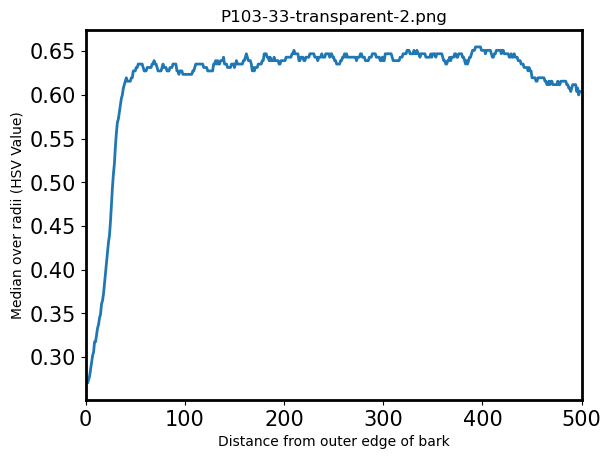

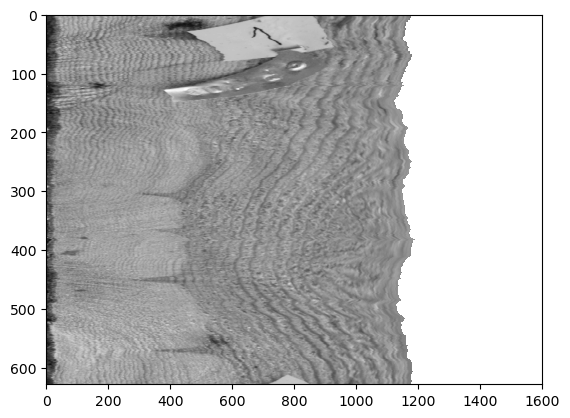

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv
from scipy.ndimage import center_of_mass

def compute_bark_thickness(image_path):
    # Load the image and mask
    image = imread(image_path)
    if image.shape[-1] == 4:
        rgb_image = image[..., :3]
        mask = image[..., 3]  # Assuming the 4th channel is the mask
    else: 
        raise ValueError("Image does not have a mask channel")

    # Convert RGB to HSV and extract the value component
    hsv_image = rgb2hsv(rgb_image)
    value_component = hsv_image[..., 2]

    # Initialize matrix for value along radii
    value_matrix = -1 * np.ones((3601, 629))

    # Calculate the center of the mask
    center_x, center_y = center_of_mass(mask)

    # Loop through angles to compute radii values
    idx = 0
    for angle in np.arange(0, 2 * np.pi, 0.01):
        value_vector = return_value_component_along_radius(value_component, mask, angle, center_x, center_y)
        
        # Reverse the vector (from center-to-edge to edge-to-center)
        value_vector = value_vector[::-1]

        # Find the bark's edge (non-masked part)
        i = 0
        while i < len(value_vector) and value_vector[i] == -1:
            i += 1

        # Remove parts outside the mask
        value_vector = value_vector[i:]

        # Save the processed vector into the matrix
        value_matrix[:len(value_vector), idx] = value_vector
        idx += 1

    # Replace -1 values with NaN for nanmedian to ignore them
    value_matrix[value_matrix == -1] = np.nan

    # Plot the median curve over all radii; limit x-axis to between 0..500
    plt.figure(1)
    
    # Compute the nanmedian along valid radii
    median_curve = np.nanmedian(value_matrix, axis=1)
    
    plt.plot(median_curve, linewidth=2)
    plt.xlim([0, 500])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Set linewidth for the plot frame spines
    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)
    
    # Set axis labels and title
    plt.title(image_path.split('/')[-1].replace('_', '-'))
    plt.ylabel('Median over radii (HSV Value)')
    plt.xlabel('Distance from outer edge of bark')
    
    # Display the plot
    plt.show()

    # Plot the value matrix image
    plt.figure(2)
    plt.imshow(value_matrix.T, aspect='auto', cmap='gray')
    plt.xlim([0, 1600])
    plt.show()

def return_value_component_along_radius(value_component, mask, angle, center_x, center_y):
    width, height = value_component.shape
    longest_radius = int(np.floor(np.sqrt(width**2 + height**2) / 2))
    value_vector = -1 * np.ones(longest_radius + 1)

    # Traverse from center to edge
    for c in range(longest_radius + 1):
        x = int(center_x + c * np.cos(angle))
        y = int(center_y + c * np.sin(angle))

        if 0 <= x < width and 0 <= y < height:
            if mask[x, y] == 255:  # Inside mask area
                value_vector[c] = value_component[x, y]
    
    return value_vector

# Call the function with the image path
compute_bark_thickness("bark_thickness/images/P103-33_transparent_2.png")


## Bark Thickness - Derivative Aproach

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv
import numpy.polynomial.polynomial as poly

def compute_bark_thickness(image_path, save_dir):
    """Computes bark thickness and saves the plot."""
    image = imread(image_path)
    rgb_image = image[..., :3]
    mask = (image[..., 3] > 0).astype(np.uint8) * 255  # Alpha channel, used later for determining valid image area
    
    hsv_image = rgb2hsv(rgb_image)
    value_component = hsv_image[..., 2]

    value_matrix = -1 * np.ones((3601, 629))
    center_x, center_y = image.shape[0] / 2, image.shape[1] / 2
    
    idx = 0
    for angle in np.arange(0, 2 * np.pi, 0.01):
        value_vector = return_value_component_along_radius(value_component, mask, angle, center_x, center_y)
        value_vector = value_vector[::-1]

        i = 0
        while i < len(value_vector) and value_vector[i] == -1:
            i += 1

        value_vector = value_vector[i:]
        value_matrix[:len(value_vector), idx] = value_vector
        idx += 1

    value_matrix[value_matrix == -1] = np.nan
    median_curve = np.nanmedian(value_matrix, axis=1)
    
    # Compute derivative analysis
    thickness_ranges = np.arange(20, 501, 5)
    table_of_derivatives = np.zeros((500, len(thickness_ranges)))
    
    for i, t_range in enumerate(thickness_ranges):
        x = np.arange(1, t_range + 1)
        poly_fit = poly.Polynomial.fit(x, median_curve[:t_range], 5)
        derivative_values = poly_fit.deriv()(x)
        table_of_derivatives[:len(derivative_values), i] = derivative_values
    
    smoothed_mean_derivative = np.convolve(np.nanmean(table_of_derivatives, axis=1), np.ones(5)/5, mode='valid')
    thickness = np.argmax(smoothed_mean_derivative)
    peak_derivative_value = np.max(smoothed_mean_derivative)

    # Plot and save median curve
    plt.figure(figsize=(8, 5))
    plt.plot(median_curve, color="blue", linestyle="dashed", label="Median Curve", alpha=0.6)
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Median over radii (HSV Value)", fontsize=14)
    plt.title(f"Median Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    
    plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_curve.png"
    plot_path = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.close()
    
    # Plot and save smoothed derivative curve
    plt.figure(figsize=(8, 5))
    plt.plot(smoothed_mean_derivative, linewidth=2, color='red', label='Smoothed Mean Derivative')
    plt.axvline(x=thickness, color='black', linestyle='--', label=f'Thickness ({thickness})')
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Smoothed Mean Derivative", fontsize=14)
    plt.title(f"Smoothed Derivative Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    
    derivative_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_derivative_curve.png"
    derivative_plot_path = os.path.join(save_dir, derivative_plot_filename)
    plt.savefig(derivative_plot_path, dpi=300, bbox_inches="tight")
    plt.close()
    
    return thickness, peak_derivative_value, os.path.basename(image_path), plot_path, derivative_plot_path

def return_value_component_along_radius(value_component, mask, angle, center_x, center_y):
    width, height = value_component.shape
    longest_radius = int(np.floor(np.sqrt(width**2 + height**2) / 2))
    value_vector = -1 * np.ones(longest_radius + 1)

    for c in range(longest_radius + 1):
        x = int(center_x + c * np.cos(angle))
        y = int(center_y + c * np.sin(angle))

        if 0 <= x < width and 0 <= y < height:
            if mask[x, y] == 255:
                value_vector[c] = value_component[x, y]
    
    return value_vector

def extract_id(filename):
    match = re.match(r"([A-Za-z0-9]+)-", filename)
    return match.group(1) if match else "Unknown"

def process_folder(input_folder, output_csv, plot_folder):
    os.makedirs(plot_folder, exist_ok=True)
    results_by_id = {}

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            thickness, peak_derivative_value, image_name, plot_path, derivative_plot_path = compute_bark_thickness(image_path, plot_folder)

            if thickness is not None:
                image_id = extract_id(filename)
                if image_id not in results_by_id:
                    results_by_id[image_id] = []
                results_by_id[image_id].append((image_name, thickness))

    for image_id in results_by_id:
        results_by_id[image_id].sort(key=lambda x: x[1])

    with open(output_csv, "w") as f:
        f.write("ID,image_name,thickness,peak_derivative_value\n")
        for image_id, images in results_by_id.items():
            for image_name, thickness in images:
                f.write(f"{image_id},{image_name},{thickness}\n")

    print(f"Results saved to {output_csv}")
    print(f"Plots saved in {plot_folder}")


input_folder = "bark_thickness/contrast_test/ends"
output_csv = "bark_thickness/test_results_3.csv"
plot_folder = "bark_thickness/plots3"

# Process the folder
process_folder(input_folder, output_csv, plot_folder)

## Bark Thickness Min or Max Derivative - Transformed Plot

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv
import numpy.polynomial.polynomial as poly

def compute_bark_thickness(image_path, save_dir):
    """Computes bark thickness and saves multiple plots including overlay on transformed image."""
    image = imread(image_path)
    rgb_image = image[..., :3]
    mask = (image[..., 3] > 0).astype(np.uint8) * 255  # Alpha channel as mask
    
    hsv_image = rgb2hsv(rgb_image)
    """Select appropriate component to be used in computation Saturation or Value."""
    component = hsv_image[..., 2] # Value
    #component = hsv_image[..., 1] # Saturation
    
    value_matrix = -1 * np.ones((3601, 629))
    center_x, center_y = image.shape[0] / 2, image.shape[1] / 2
    
    idx = 0
    for angle in np.arange(0, 2 * np.pi, 0.01): # Default 0.01 steps
        value_vector = return_component_along_radius(component, mask, angle, center_x, center_y)
        value_vector = value_vector[::-1]

        i = 0
        while i < len(value_vector) and value_vector[i] == -1:
            i += 1

        value_vector = value_vector[i:]
        value_matrix[:len(value_vector), idx] = value_vector
        idx += 1

    value_matrix[value_matrix == -1] = np.nan
    median_curve = np.nanmedian(value_matrix, axis=1)
    
    # Compute derivative analysis
    thickness_ranges = np.arange(20, 306, 5)
    table_of_derivatives = np.zeros((500, len(thickness_ranges)))
    
    for i, t_range in enumerate(thickness_ranges):
        x = np.arange(1, t_range + 1)
        poly_fit = poly.Polynomial.fit(x, median_curve[:t_range], 5)
        derivative_values = poly_fit.deriv()(x)
        table_of_derivatives[:len(derivative_values), i] = derivative_values
    
    smoothed_mean_derivative = np.convolve(np.nanmean(table_of_derivatives, axis=1), np.ones(5)/5, mode='valid')

    """Use variables below if using Value component of HSV."""
    thickness = np.argmax(smoothed_mean_derivative)
    peak_derivative_value = np.max(smoothed_mean_derivative)
    
    """Use variables below if using Satuation component of HSV."""
    #thickness = np.argmin(smoothed_mean_derivative)
    #peak_derivative_value = np.min(smoothed_mean_derivative)
        
    ### Save Median Curve Plot ###
    plt.figure(figsize=(8, 5))
    plt.plot(median_curve, color="blue", linestyle="dashed", label="Median Curve", alpha=0.6)
    plt.axvline(x=thickness, color='red', linestyle='--', label=f'Thickness ({thickness})')
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Median over radii (HSV Value)", fontsize=14)
    plt.title(f"Median Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)

    median_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_median_curve.png"
    median_plot_path = os.path.join(save_dir, median_plot_filename)
    plt.savefig(median_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    ### Save Smoothed Derivative Curve ###
    plt.figure(figsize=(8, 5))
    plt.plot(smoothed_mean_derivative, linewidth=2, color='red', label='Smoothed Mean Derivative')
    plt.axvline(x=thickness, color='blue', linestyle='--', label=f'Thickness ({thickness})')
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Smoothed Mean Derivative", fontsize=14)
    plt.title(f"Smoothed Derivative Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)

    derivative_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_derivative_curve.png"
    derivative_plot_path = os.path.join(save_dir, derivative_plot_filename)
    plt.savefig(derivative_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    ### Save Overlay of Thickness Estimate on Transformed Image ###
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot the transformed bark image (without exporting it separately)
    ax1.imshow(value_matrix.T, cmap="gray", interpolation="nearest", aspect='auto')
    ax1.set_title(f"Transformed Image with Estimated Thickness ({os.path.basename(image_path)})")
    #ax1.set_xlabel("Radius")
    #ax1.set_ylabel("Distance from Outer Edge")
    ax1.set_xlim([0, 1400])  # Ensuring proper scaling

    # Overlay only the estimated thickness line
    ax1.axvline(x=thickness, color='red', linestyle='--', linewidth=2, label=f"Estimated Thickness ({thickness})")
    ax1.legend(loc="upper left")

    # Save the overlay plot
    overlay_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_overlay_transformed.png"
    overlay_plot_path = os.path.join(save_dir, overlay_plot_filename)
    plt.savefig(overlay_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    return thickness, peak_derivative_value, os.path.basename(image_path), median_plot_path, derivative_plot_path, overlay_plot_path

def return_component_along_radius(component, mask, angle, center_x, center_y):
    width, height = component.shape
    longest_radius = int(np.floor(np.sqrt(width**2 + height**2) / 2))
    component_vector = -1 * np.ones(longest_radius + 1)

    for r in range(longest_radius + 1):
        x = int(center_x + r * np.cos(angle))
        y = int(center_y + r * np.sin(angle))

        if 0 <= x < width and 0 <= y < height:
            if mask[x, y] == 255:
                component_vector[r] = component[x, y]
    
    return component_vector

def extract_id(filename):
    match = re.match(r"([A-Za-z0-9]+)-", filename)
    return match.group(1) if match else "Unknown"

def process_folder(input_folder, output_csv):
    print("📂 Starting bark thickness analysis...")  # Start message
    results_by_id = {}

    for subdir, _, files in os.walk(input_folder):
        if os.path.basename(subdir) != "ends":  
            continue  # Skip folders that are not the target folder

        png_files = [f for f in files if f.endswith(".png")]
        if not png_files:
            continue  # Skip if no PNG files are found in the target folder

        parent_folder = os.path.dirname(subdir)  # Get the parent folder of 'target'
        plot_folder = os.path.join(parent_folder, "plots")  # Save plots in the parent folder
        os.makedirs(plot_folder, exist_ok=True)

        print(f"\n🎯 Processing target folder: {subdir} ({len(png_files)} images)")

        for filename in png_files:
            image_path = os.path.join(subdir, filename)
            print(f"  📷 Processing image: {filename}...")

            try:
                thickness, peak_derivative_value, image_name, median_plot_path, derivative_plot_path, overlay_plot_path = compute_bark_thickness(image_path, plot_folder)

                if thickness is not None:
                    image_id = extract_id(filename)
                    if image_id not in results_by_id:
                        results_by_id[image_id] = []
                    results_by_id[image_id].append((image_name, thickness))
                    
                    print(f"    ✅ Thickness computed: {thickness} (Saved to {plot_folder})")
                else:
                    print(f"    ⚠️ Skipping {filename} (No valid thickness found)")

            except Exception as e:
                print(f"    ❌ Error processing {filename}: {e}")

    # Sort results by thickness
    for image_id in results_by_id:
        results_by_id[image_id].sort(key=lambda x: x[1])

    # Write results to CSV
    print("\n💾 Saving results to CSV...")
    write_header = not os.path.exists(output_csv) or os.stat(output_csv).st_size == 0  # Check if file is new or empty

    with open(output_csv, "a") as f:
        if write_header:
            f.write("ID,file_name,thickness\n")  # Write header only once
    
        for image_id, images in results_by_id.items():
            for image_name, thickness in images:
                f.write(f"{image_id},{image_name.replace('.png', '')},{thickness}\n")

input_folder = 'bark_thickness/contrast_test'
output_csv = "bark_thickness/contrast_test_extended_max_V.csv"

# Process the folder
process_folder(input_folder, output_csv)

## Bark Thickness Vmax - Smin Approach

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv
import numpy.polynomial.polynomial as poly

def compute_bark_thickness(image_path, save_dir, save_all_plots=False):
    image = imread(image_path)
    rgb_image = image[..., :3]
    mask = (image[..., 3] > 0).astype(np.uint8) * 255
    hsv_image = rgb2hsv(rgb_image)
    center_x, center_y = image.shape[0] / 2, image.shape[1] / 2

    results = {}

    for mode, component_label in zip([2, 1], ['value', 'saturation']):
        component = hsv_image[..., mode]
        value_matrix = -1 * np.ones((3601, 629))

        idx = 0
        for angle in np.arange(0, 2 * np.pi, 0.01):
            value_vector = return_component_along_radius(component, mask, angle, center_x, center_y)
            value_vector = value_vector[::-1]
            i = 0
            while i < len(value_vector) and value_vector[i] == -1:
                i += 1
            value_vector = value_vector[i:]
            value_matrix[:len(value_vector), idx] = value_vector
            idx += 1

        value_matrix[value_matrix == -1] = np.nan
        median_curve = np.nanmedian(value_matrix, axis=1)

        # Check for all-NaN
        if np.all(np.isnan(median_curve[:300])):
            print(f"    ⚠️ Skipping {component_label} computation (insufficient data)")
            results[component_label] = {
                'thickness': None,
                'peak': None,
                'value_matrix': value_matrix.T,
                'median_curve': median_curve,
                'smoothed_derivative': None
            }
            continue

        thickness_ranges = np.arange(20, 306, 5)
        table_of_derivatives = np.full((500, len(thickness_ranges)), np.nan)

        for i, t_range in enumerate(thickness_ranges):
            x = np.arange(1, t_range + 1)
            y = median_curve[:t_range]
            if np.any(np.isnan(y)) or len(y) < 6:
                continue  # Skip invalid curve sections

            try:
                poly_fit = poly.Polynomial.fit(x, y, 5)
                derivative_values = poly_fit.deriv()(x)
                table_of_derivatives[:len(derivative_values), i] = derivative_values
            except (ValueError, np.linalg.LinAlgError):
                continue  # Skip bad fit

        if np.all(np.isnan(table_of_derivatives)):
            print(f"    ⚠️ No valid derivative for {component_label}")
            thickness = None
            peak = None
            smoothed_mean_derivative = None
        else:
            smoothed_mean_derivative = np.convolve(np.nanmean(table_of_derivatives, axis=1), np.ones(5)/5, mode='valid')
            if component_label == 'value':
                thickness = int(np.nanargmax(smoothed_mean_derivative))
                peak = float(np.nanmax(smoothed_mean_derivative))
            else:
                thickness = int(np.nanargmin(smoothed_mean_derivative))
                peak = float(np.nanmin(smoothed_mean_derivative))

        results[component_label] = {
            'thickness': thickness,
            'peak': peak,
            'value_matrix': value_matrix.T,
            'median_curve': median_curve,
            'smoothed_derivative': smoothed_mean_derivative
        }

        # Optional plot exports
        if save_all_plots:
            plt.figure(figsize=(8, 5))
            plt.plot(median_curve, color="blue", linestyle="dashed", label="Median Curve", alpha=0.6)
            plt.axvline(x=thickness, color='red', linestyle='--', label=f'Thickness ({thickness})')
            plt.xlabel("Distance from outer edge of bark")
            plt.ylabel(f"Median over radii (HSV {component_label.title()})")
            plt.title(f"Median Curve ({component_label}) - {os.path.basename(image_path)}")
            plt.legend()
            plt.grid(True, linestyle="--", alpha=0.6)
            ax1.set_xlim([0, 1400])  # Ensuring proper scaling
            plt.savefig(os.path.join(save_dir, f"{os.path.basename(image_path).replace('.png', '')}_median_curve_{component_label}.png"), dpi=300, bbox_inches="tight")
            plt.close()

            plt.figure(figsize=(8, 5))
            plt.plot(smoothed_mean_derivative, linewidth=2, color='red')
            plt.axvline(x=thickness, color='blue', linestyle='--', label=f'Thickness ({thickness})')
            plt.title(f"Smoothed Derivative ({component_label}) - {os.path.basename(image_path)}")
            plt.legend()
            plt.grid(True, linestyle="--", alpha=0.6)
            ax1.set_xlim([0, 1400])  # Ensuring proper scaling
            plt.savefig(os.path.join(save_dir, f"{os.path.basename(image_path).replace('.png', '')}_derivative_curve_{component_label}.png"), dpi=300, bbox_inches="tight")
            plt.close()

    ### Overlay plot with both Value and Saturation thickness ###
    if results['value']['thickness'] is not None or results['saturation']['thickness'] is not None:
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.imshow(results['value']['value_matrix'], cmap="gray", aspect='auto')
        if results['value']['thickness'] is not None:
            ax1.axvline(x=results['value']['thickness'], color='red', linestyle='--', linewidth=2, label=f"Value ({results['value']['thickness']})")
        if results['saturation']['thickness'] is not None:
            ax1.axvline(x=results['saturation']['thickness'], color='blue', linestyle='--', linewidth=2, label=f"Saturation ({results['saturation']['thickness']})")
        ax1.set_title(f"Overlay Thickness - {os.path.basename(image_path)}")
        ax1.legend(loc="upper right")
        overlay_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_overlay_transformed.png"
        overlay_plot_path = os.path.join(save_dir, overlay_plot_filename)
        ax1.set_xlim([0, 1400])  # Ensuring proper scaling
        plt.savefig(overlay_plot_path, dpi=300, bbox_inches="tight")
        plt.close()
    else:
        overlay_plot_path = "None"


    return (results['value']['thickness'], results['value']['peak'],
            results['saturation']['thickness'], results['saturation']['peak'],
            os.path.basename(image_path), overlay_plot_path)


def return_component_along_radius(component, mask, angle, center_x, center_y):
    width, height = component.shape
    longest_radius = int(np.floor(np.sqrt(width**2 + height**2) / 2))
    component_vector = -1 * np.ones(longest_radius + 1)

    for r in range(longest_radius + 1):
        x = int(center_x + r * np.cos(angle))
        y = int(center_y + r * np.sin(angle))

        if 0 <= x < width and 0 <= y < height:
            if mask[x, y] == 255:
                component_vector[r] = component[x, y]
    
    return component_vector

def extract_id(filename):
    match = re.match(r"([A-Za-z0-9]+)-", filename)
    return match.group(1) if match else "Unknown"

def process_folder(input_folder, output_csv):
    print("📂 Starting bark thickness analysis...")  # Start message
    results_by_id = {}

    for subdir, _, files in os.walk(input_folder):
        if os.path.basename(subdir) != "ends":  
            continue  # Skip folders that are not the target folder

        png_files = [f for f in files if f.endswith(".png")]
        if not png_files:
            continue  # Skip if no PNG files are found in the target folder

        parent_folder = os.path.dirname(subdir)  # Get the parent folder of 'target'
        plot_folder = os.path.join(parent_folder, "plots")  # Save plots in the parent folder
        os.makedirs(plot_folder, exist_ok=True)

        print(f"\n🎯 Processing target folder: {subdir} ({len(png_files)} images)")

        for filename in png_files:
            image_path = os.path.join(subdir, filename)
            print(f"  📷 Processing image: {filename}...")

            try:
                thickness_val, peak_val, thickness_sat, peak_sat, image_name, overlay_plot_path = compute_bark_thickness(image_path, plot_folder, save_all_plots=False)

                if thickness_val is not None or thickness_sat is not None:
                    image_id = extract_id(filename)
                    if image_id not in results_by_id:
                        results_by_id[image_id] = []
                    results_by_id[image_id].append((image_name, thickness_val, peak_val, thickness_sat, peak_sat))
                    
                    print(f"    ✅ Thickness computed: Value={thickness_val}, Saturation={thickness_sat} (Saved to {plot_folder})")
                else:
                    print(f"    ⚠️ Skipping {filename} (No valid thickness found)")


            except Exception as e:
                print(f"    ❌ Error processing {filename}: {e}")

    # Sort results by thickness
    for image_id in results_by_id:
        results_by_id[image_id].sort(key=lambda x: x[1])

    # Write results to CSV
    print("\n💾 Saving results to CSV...")
    write_header = not os.path.exists(output_csv) or os.stat(output_csv).st_size == 0  # Check if file is new or empty

    with open(output_csv, "a") as f:
        if write_header:
            f.write("ID,file_name,thickness_value,thickness_saturation\n")
            #f.write("ID,file_name,thickness_value,peak_value,thickness_saturation,peak_saturation\n")  # Write header only once
    
        for image_id, images in results_by_id.items():
            for image_name, thickness_val, peak_val, thickness_sat, peak_sat in images:
                f.write(f"{image_id},{image_name.replace('.png', '')},{thickness_val or ''},{thickness_sat or ''}\n")



input_folder = 'bark_thickness\contrast_correction\processed'
output_csv = "thickness_double_test2_analysis.csv"

# Process the folder
process_folder(input_folder, output_csv)

In [ ]:
def process_folder(input_folder, output_csv, plot_folder):
    os.makedirs(plot_folder, exist_ok=True)
    results_by_id = {}

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            thickness, peak_derivative_value, image_name, median_plot_path, derivative_plot_path, overlay_plot_path = compute_bark_thickness(image_path, plot_folder)

            if thickness is not None:
                image_id = extract_id(filename)
                if image_id not in results_by_id:
                    results_by_id[image_id] = []
                results_by_id[image_id].append((image_name, thickness))

    for image_id in results_by_id:
        results_by_id[image_id].sort(key=lambda x: x[1])

    with open(output_csv, "w") as f:
        f.write("ID,image_name,thickness,peak_derivative_value\n")
        for image_id, images in results_by_id.items():
            for image_name, thickness in images:
                f.write(f"{image_id},{image_name},{thickness}\n")

    print(f"Results saved to {output_csv}")
    print(f"Plots saved in {plot_folder}")


input_folder = "bark_thickness/non_normal"
output_csv = "bark_thickness/test_results_non_normal.csv"
plot_folder = "bark_thickness/plots_non_normal"

# Process the folder
process_folder(input_folder, output_csv, plot_folder)

# Bark Thickness Conversion from Pixel to Metric

### Exract Date information and Assign Groups

Since there is no standart for photography sessions, to correct for camera distance, images taken on same day will be processed together in bark thickness conversion from pixel to metric. 

In [5]:
import os
import re
from PIL import Image
from PIL.ExifTags import TAGS
import pandas as pd

# Path to the two main folders
main_folders = ["D:\internship_images\pine_sites", "D:\internship_images\spruce_sites", "D:\internship_images\extras\pine", "D:\internship_images\extras\spruce"]

# Name of the folder that actually contains the images
target_folder_name = "original" 

records = []

def extract_id(filename):
    name = os.path.splitext(filename)[0]  # remove extension
    return name.split("-")[0] if "-" in name else None

def get_exif_date(image_path):
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        if exif_data:
            for tag, value in exif_data.items():
                tag_name = TAGS.get(tag, tag)
                if tag_name in ["DateTimeOriginal", "DateTimeDigitized", "DateTime"]:
                    # Format: "YYYY:MM:DD HH:MM:SS"
                    date_str = value.split(" ")[0]  # only YYYY:MM:DD
                    year, month, day = date_str.split(":")
                    return f"{day}-{month}-{year}"  # day-month-year
    except Exception as e:
        print(f"Error reading EXIF from {image_path}: {e}")
    return None

# Walk through the folder structure
for folder in main_folders:
    for root, dirs, files in os.walk(folder):
        # Check if target folder name appears in the path
        if target_folder_name in root:
            for file in files:
                if file.lower().endswith((".jpg")):
                    file_path = os.path.join(root, file)
                    date_taken = get_exif_date(file_path)
            
                    # Extract ID from filename
                    ID = extract_id(file)
            
                    # Remove file extension
                    file_name_no_ext = os.path.splitext(file)[0]
            
                    # Store record
                    if date_taken:
                        records.append([ID, file_name_no_ext, date_taken])


# Create DataFrame
df = pd.DataFrame(records, columns=["ID", "file_name", "date"])

if not df.empty:
    # Assign group numbers based on unique dates
    df["group"] = df.groupby("date").ngroup() + 1
    # Save to Excel
    df.to_excel("photo_dates.xlsx", index=False)
    print("✅ Excel file 'photo_dates.xlsx' created successfully!")
else:
    print("⚠️ No EXIF dates found. Check folder name or image metadata.")

✅ Excel file 'photo_dates.xlsx' created successfully!


### Extract Diameter in Pixels using Measured Diameter 

In [11]:
import cv2
import numpy as np
import os

# --- Input data ---
imgPath1 = 'thickness_conversion_samples/S6-696.png'
measuredDiam1 = 20
imgPath2 = 'thickness_conversion_samples/S220-606.png'
measuredDiam2 = 21
imgPath3 = 'thickness_conversion_samples/S223-852.png'
measuredDiam3 = 22

# Hardcoded selection of image to be processed
imgPath = imgPath3
measuredDiam = measuredDiam3

def rotate_image_keep_bounds(image, angle):
    """Rotate image without cropping."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # rotation matrix
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)

    # compute new bounding dimensions
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # adjust translation to keep image centered
    rot_mat[0, 2] += (new_w / 2) - center[0]
    rot_mat[1, 2] += (new_h / 2) - center[1]

    # perform rotation
    return cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_NEAREST)


# --- Read alpha channel (mask) ---
img = cv2.imread(imgPath, cv2.IMREAD_UNCHANGED)  # includes alpha if present
if img is None:
    raise FileNotFoundError(f"Could not read {imgPath}")

if img.shape[2] < 4:
    raise ValueError(f"{imgPath} does not have an alpha channel")

alpha = img[:, :, 3]  # alpha channel
sz = alpha.shape
height = 0
diameter = 0

# --- Rotate 0:5:90 degrees and find max side ---
for angle in range(0, 91, 5):
    # rotate
    h, w = alpha.shape
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = rotate_image_keep_bounds(alpha, angle)

    # trim empty rows/cols
    cols = np.any(rotated > 0, axis=0)
    rows = np.any(rotated > 0, axis=1)
    rotated = rotated[np.ix_(rows, cols)]

    # check longest side
    if rotated.shape[0] > height:
        height = rotated.shape[0]
        diameter = rotated.shape[1]

    if rotated.shape[1] > height:
        height = rotated.shape[1]
        diameter = rotated.shape[0]

# --- Print results ---
file_name = os.path.basename(imgPath)
print(f"\n            Image = {file_name}")
print(f"       Image size = {sz[1]} x {sz[0]}")  # width x height
print(f"         Diameter = {diameter} pixels (corresponding long side = {height} pixels)")
print(f"Measured diameter = {measuredDiam} cm")
print(f"    Pixels per cm = {diameter / measuredDiam:.1f}")


            Image = S223-852.png
       Image size = 1762 x 1735
         Diameter = 1745 pixels (corresponding long side = 1810 pixels)
Measured diameter = 22 cm
    Pixels per cm = 79.3


### Folder version

In [14]:
import cv2
import numpy as np
import pandas as pd
import os

# --- rotation helper (keeps full image, no cropping) ---
def rotate_image_keep_bounds(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    rot_mat[0, 2] += (new_w / 2) - center[0]
    rot_mat[1, 2] += (new_h / 2) - center[1]

    return cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_NEAREST)

# --- parameters ---
dataset_path = "thickness_conversion_samples/diameter_data.csv"              # your dataset with file_name, diameter
image_folder = "thickness_conversion_samples"     # folder where PNGs are stored
output_csv = "rotation_results.csv"

# --- load dataset ---
df = pd.read_csv(dataset_path)

results = []

# --- process each image ---
for _, row in df.iterrows():
    fname = str(row["file_name"]) + ".png"
    measuredDiam = row["diameter"]

    imgPath = os.path.join(image_folder, fname)
    img = cv2.imread(imgPath, cv2.IMREAD_UNCHANGED)

    if img is None:
        print(f"⚠️ Could not read {imgPath}, skipping...")
        continue

    if img.shape[2] < 4:
        print(f"⚠️ {fname} has no alpha channel, skipping...")
        continue

    alpha = img[:, :, 3]
    sz = alpha.shape
    height = 0
    diameter = 0

    # rotate 0:5:90
    for angle in range(0, 91, 5):
        rotated = rotate_image_keep_bounds(alpha, angle)

        # trim empty rows/cols
        cols = np.any(rotated > 0, axis=0)
        rows = np.any(rotated > 0, axis=1)
        rotated = rotated[np.ix_(rows, cols)]

        # check longest side
        if rotated.shape[0] > height:
            height = rotated.shape[0]
            diameter = rotated.shape[1]

        if rotated.shape[1] > height:
            height = rotated.shape[1]
            diameter = rotated.shape[0]

    pixels_per_cm = diameter / measuredDiam

    results.append({
        "file_name": row["file_name"],
        #"image_width": sz[1],
        #"image_height": sz[0],
        #"diameter_pixels": diameter,
        #"long_side_pixels": height,
        "measured_diameter_cm": measuredDiam,
        "pixels_per_cm": round(pixels_per_cm, 1)
    })

    print(f"✅ {fname} -> {diameter} px / {measuredDiam} cm = {pixels_per_cm:.1f} px/cm")

# --- save results ---
results_df = pd.DataFrame(results)
results_df.to_csv(output_csv, index=False)
print(f"\nResults saved to {output_csv}")


✅ S6-696.png -> 1820 px / 20 cm = 91.0 px/cm
✅ S220-606.png -> 1604 px / 21 cm = 76.4 px/cm
✅ S223-852.png -> 1745 px / 22 cm = 79.3 px/cm
✅ P29-63.png -> 2604 px / 28 cm = 93.0 px/cm
✅ P189-99.png -> 2759 px / 29 cm = 95.1 px/cm
✅ P193-105.png -> 3029 px / 38 cm = 79.7 px/cm
✅ S21-174.png -> 1895 px / 18 cm = 105.3 px/cm
✅ S68-180.png -> 2028 px / 19 cm = 106.7 px/cm
✅ S99-150.png -> 2411 px / 22 cm = 109.6 px/cm
✅ S151-192.png -> 1988 px / 19 cm = 104.6 px/cm

Results saved to rotation_results.csv


# Helper Code

 Related to house keeping task. Data cleaning, file name modifications, missing data and such.

## Join Data

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('cleaned_data/full_dataset_spruce_pine.csv')

# Remove everything after "_" in the "ID" column
#df['ID'] = df['ID'].apply(lambda x: x.split('_')[0])

# Save the cleaned CSV file
#df.to_csv('cleaned_file.csv', index=False)

#print("IDs cleaned and saved to cleaned_file.csv")

# Load your cleaned CSV and main dataset
df_cleaned = df
df_main = pd.read_csv('cleaned_data/extras_andmissing_ID_cleaned.csv')

# Concatenate the two dataframes
df_merged = pd.concat([df_cleaned, df_main], ignore_index=True)

# Save the merged dataset
df_merged.to_csv('full_dataset.csv', index=False)

print("Merging complete. Saved as 'merged_dataset.csv'")

## Sort Data

In [29]:
import pandas as pd

# Load your CSV file into a DataFrame
input_file = "cleaned_data/full_dataset.csv"  
output_file = "cleaned_data/sorted_full_dataset.csv"

df = pd.read_csv(input_file)

# Sort the DataFrame by the 'ID' column
df_sorted = df.sort_values(by='ID', ascending=True)

# Save the sorted DataFrame back to a CSV file
df_sorted.to_csv(output_file, index=False)

print(f"Data sorted by 'ID' and saved to {output_file}")


Data sorted by 'ID' and saved to cleaned_data/sorted_full_dataset.csv


## ID Count

In [15]:
import pandas as pd
# Load DataFrame
#data = pd.read_csv("cleaned_data/spruce_data_cleaned.csv")
data = pd.read_csv("cleaned_data/sorted_full_dataset.csv")
df_clean_full = pd.DataFrame(data)

# Extract the repeating part of the ID (the part before '-')
df_clean_full['ID_Part'] = df_clean_full['ID'].str.split('-').str[0]

# Count how many times each ID_Part occurs
id_counts = df_clean_full['ID_Part'].value_counts()

# Identify IDs that don't appear 6 times
ids_missing = id_counts[id_counts != 6]

#Print the IDs and their occurrence counts (which are not 6)
#print("IDs missing some entries (not appearing 6 times):")
#print(ids_missing)

# Print the missing IDs and their occurrences specifically
for id_part, count in ids_missing.items():
    print(f"ID: {id_part}, Present {count} times (Missing {6 - count} times)")

# Open a text file to write the output
with open('id_counts/full_Data_idcounts_report.txt', 'w') as file:
    file.write(f"Row count: {len(df_clean_full)}\n")
    for id_part, count in ids_missing.items():
        file.write(f"ID: {id_part}, Present {count} times (Missing {6 - count} times)\n")

print("Output written to ids_report.txt")

# Full row data of the missing IDs,  can filter them out
missing_rows = df_clean_full[df_clean_full['ID_Part'].isin(ids_missing.index)]
print("Rows with IDs missing:")
print(missing_rows)

# Define the specific ID_Part you're looking for
specific_id_part = "P7"  # Replace with the specific ID part you want to print
specific_id_part2 = "P160"

# Filter the rows where ID_Part matches the specific ID
matching_rows = df_clean_full[df_clean_full['ID_Part'] == specific_id_part]
matching_rows2 = df_clean_full[df_clean_full['ID_Part'] == specific_id_part2]

# Print the rows with the specific ID
print(f"Rows with ID part '{specific_id_part}':")
print(f"Rows with ID part '{specific_id_part2}':")

print(matching_rows)
print(matching_rows2)

Output written to ids_report.txt
Rows with IDs missing:
Empty DataFrame
Columns: [ID, area, top_left_x, top_left_y, ID_Part]
Index: []
Rows with ID part 'P7':
Rows with ID part 'P160':
          ID     area  top_left_x  top_left_y ID_Part
1266  P7-208  5519687      1003.0      1824.0      P7
1267  P7-209  5537393       988.0      1791.0      P7
1268  P7-210  5641934       926.0      1782.0      P7
1269  P7-211  5437077      1016.0      1824.0      P7
1270  P7-212  3126683       864.0      2524.0      P7
1271  P7-213  2929244      1125.0      2648.0      P7
           ID     area  top_left_x  top_left_y ID_Part
408  P160-985  9875740       470.0      1814.0    P160
409  P160-986  9111508       335.0      1787.0    P160
410  P160-987  9187055       512.0      1850.0    P160
411  P160-988  9272292       806.0      1907.0    P160
412  P160-989  6587888       922.0      1868.0    P160
413  P160-990  6819776        25.0      1746.0    P160


## Excel Data Exploration

In [3]:
import os
import pandas as pd

# Load the CSV file
file_path = 'Log pictures2.csv'  

# Read the Excel file
df = pd.read_csv(file_path, delimiter=';')

# Print the initial number of rows to inspect
print(f"Initial number of rows: {len(df)}")

# Drop rows where all elements are NaN (likely to be empty rows)
df_cleaned = df.dropna(how='all')

# Find duplicates in the 'Log_ID' column
duplicates = df_cleaned[df_cleaned.duplicated(subset='Log_ID', keep=False)]

# Display the duplicate rows
print("Duplicate Rows Based on 'Log_ID' Column:")
print(duplicates)
print(f"Initial number of rows: {len(df_cleaned)}")
# Optionally, save the duplicates to a new CSV file
#duplicates.to_csv('duplicates.csv', index=False)

Initial number of rows: 65535
Duplicate Rows Based on 'Log_ID' Column:
    Log_ID  Photo_1-2  Photo_2-3  Photo_3-4  Photo_4-1  Photo_top  \
78     P17      556.0      557.0      558.0      559.0      560.0   
79     P17       10.0       11.0       12.0       13.0       14.0   
131   P216      550.0      551.0      552.0      553.0      554.0   
132   P216       16.0       17.0       18.0       19.0       20.0   
218    P78      473.0      474.0      475.0      476.0      477.0   
219    P78      850.0      851.0      852.0      853.0      854.0   

     Photo_bottom  Diameter_cm Unnamed: 8  
78          561.0         20.0        NaN  
79           15.0         20.0        NaN  
131         555.0         24.0        NaN  
132          21.0         24.0        NaN  
218         478.0         29.0        NaN  
219         855.0         29.0        NaN  
Initial number of rows: 483


There are three duplicate rows with different file names. 
* P17 in Site 16
    * Actual image file names are 10-15, Remove row 78     
* P216 in Site 16
    * Actual image file names are 16-21. Remove row 131 
* P78 in site 12
    * Actual image file names are 850-855. Remove row 218

## Finding Missing Data

Cross checking with excel log of the image data.

First need to make log data comparable to SAM output data. Log data contains Log ID with image name as feature. For comparison there is a need for each row is image name with ID: **Log ID-image name**

**log_ids.csv** will be used for crosschecking SAM generated data to find out missing IDs in generated data.

In [5]:
import pandas as pd

# Step 1: Read the original data from CSV
input_file = 'Log_pictures2.csv'
df = pd.read_csv(input_file, sep=';')

# Step 2: Specify the row numbers (indices) you want to drop
rows_to_drop = [77, 129, 215]
df = df.drop(rows_to_drop)

# Step 3: Print the content of the rows to be dropped
dropped_rows = df.iloc[rows_to_drop]
print("Dropped rows:")
print(dropped_rows)


df = df.dropna()
print(df)
# Step 2: Create an empty list to hold the new rows
new_data = []

# Step 3: Iterate through each row of the DataFrame
for index, row in df.iterrows():
    log_id = row['Log_ID']
    
    # Loop through each feature
    for feature in ['Photo_1-2', 'Photo_2-3', 'Photo_3-4', 'Photo_4-1', 'Photo_top', 'Photo_bottom']:
        # Create a new Log_ID-data entry
        new_entry = {
            'Log_ID': f"{log_id}-{row[feature]}"
        }
        # Append this new entry to the new_data list
        new_data.append(new_entry)

# Step 4: Create a new DataFrame from the new_data list
new_df = pd.DataFrame(new_data)

# Step 5: Export the new DataFrame to CSV
output_file = 'log_ids.csv'
new_df.to_csv(output_file, index=False)

print(f'New CSV file saved as: {output_file}')


Dropped rows:
    Log_ID  Photo_1-2  Photo_2-3  Photo_3-4  Photo_4-1  Photo_top  \
78     P17         10         11         12         13         14   
131   P217        973        974        975        976        977   
218     P8        299        300        301        302        303   

     Photo_bottom  Diameter_cm  
78             15           20  
131           978           27  
218           304           21  
    Log_ID  Photo_1-2  Photo_2-3  Photo_3-4  Photo_4-1  Photo_top  \
0       P1        220        221        222        223        224   
1      P10        604        605        606        607        608   
2     P100        991        992        993        994        995   
3     P101        526        527        528        529        530   
4     P102        912        913        914        915        916   
..     ...        ...        ...        ...        ...        ...   
475    S95        734        735        736        737        738   
476    S96        572    

### Export Missing IDs to text

In [6]:
import pandas as pd

# Step 1: Read all three CSV files
original_file = 'log_ids.csv'
#comparison_file_1 = 'cleaned_data/pine_merged_dataset.csv'
#comparison_file_2 = 'cleaned_data/spruce_merged_dataset.csv'
comparison_file = 'cleaned_data/sorted_full_dataset.csv'

original_df = pd.read_csv(original_file, sep=';')
#comparison_df_1 = pd.read_csv(comparison_file_1)
#comparison_df_2 = pd.read_csv(comparison_file_2)
comparison_df = pd.read_csv(comparison_file)

# Step 2: Extract the unique Log_ID columns from all three files
# use an outer join to make sure we keep all Log_IDs from both files
#merged_comparison_df = pd.merge(comparison_df_1, comparison_df_2, on='ID', how='outer')

# Step 3: Extract the unique Log_IDs from both the original file and the merged comparison file
original_log_ids = original_df['Log_ID'].unique()  # Unique Log_IDs from original
#merged_comparison_log_ids = merged_comparison_df['ID'].unique()  # Unique Log_IDs from merged comparison file
comparison_log_ids = comparison_df['ID'].unique()

# Step 4: Find the missing Log_IDs in the merged comparison file compared to the original file
#missing_in_merged_comparison = set(original_log_ids) - set(merged_comparison_log_ids)
missing_in_merged_comparison = set(original_log_ids) - set(comparison_log_ids)

# Step 5: Sort the missing Log_IDs
sorted_missing_log_ids = sorted(missing_in_merged_comparison)
print(len(sorted_missing_log_ids))

# Step 6: Print and save the missing Log_IDs to a text file
output_text_file = 'missing_log_ids_fulldata.txt'

with open(output_text_file, 'w') as file:
    file.write("Missing Log_IDs in the merged comparison file:\n")
    for log_id in sorted_missing_log_ids:
        file.write(f"{log_id}\n")

print(f"Missing Log_IDs have been saved to: {output_text_file}")

0
Missing Log_IDs have been saved to: missing_log_ids_fulldata.txt


### Find Missing Files Folderpath

In [33]:
import os

# Step 1: Read the missing Log_IDs from the text file
missing_log_ids_file = 'missing_log_ids.txt'

with open(missing_log_ids_file, 'r') as file:
    missing_log_ids = file.readlines()

# Clean up the list and remove the header
missing_log_ids = [log_id.strip() for log_id in missing_log_ids if log_id.strip()]

# Step 2: Define the two main folders and the subfolder name
main_folder_1 = 'pine_sites'
main_folder_2 = 'spruce_sites'
original_folder_name = 'original'

# Step 3: Function to find files containing Log_IDs in the original folder
def find_log_id_files(log_id, folder_path):
    matching_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if log_id in file:  # Check if Log_ID is in the file name
                matching_files.append(os.path.join(root, file))
    return matching_files

# Step 4: Search for missing Log_IDs in all 'original' folders of both main folders
results = {}

# Iterate over each of the 30 subfolders for both main folders
for main_folder in [main_folder_1, main_folder_2]:
    for i in range(1, 31):  # Folder names are "Folder 1", "Folder 2", ..., "Folder 30"
        folder_path = os.path.join(main_folder, f"Site {i}", original_folder_name)

        # Search for each missing Log_ID in the current original folder
        for log_id in missing_log_ids:
            if log_id not in results:
                results[log_id] = []  # Initialize if not already done
            
            matching_files = find_log_id_files(log_id, folder_path)
            results[log_id].extend(matching_files)
            
# Step 5: Print or save the results
output_results_file = 'log_id_locations.txt'

with open(output_results_file, 'w') as file:
    for log_id, file_paths in results.items():
        file.write(f"Log_ID: {log_id}\n")
        if file_paths:
            for path in file_paths:
                file.write(f"  {path}\n")
        else:
            file.write("  None\n")
        
        file.write("\n")

print(f"Locations of missing Log_IDs have been saved to: {output_results_file}")



Locations of missing Log_IDs have been saved to: log_id_locations.txt


### Replace File Extension "JPG" with "png" in Data Set

Target exported images have transparency with "png" extension but stored data is JPG extension. Same data but name change is necessary for cleaning data.

In [2]:
import os
import pandas as pd

# Load the original CSV file
original_csv_path = 'mask_areas_missing.csv'
df = pd.read_csv(original_csv_path)

# Create a new DataFrame to avoid modifying the original one
new_df = df.copy()

# Modify the 'ID' column, replacing 'cropped' with 'transparent' and 'JPG' with 'png'
new_df['ID'] = new_df['ID'].str.replace('JPG', 'png')

# Define the path to save the new CSV file
new_csv_path = 'mask_areas_missing_IDmod.csv'

# Save the modified DataFrame to a new CSV file
new_df.to_csv(new_csv_path, index=False)

print("New dataset has been created and saved successfully.")

New dataset has been created and saved successfully.


## Rename Exported Files

Exported files contain "transparent" tag. Export algorithm saves data with "cropped" tag. Renaming image files is necessary to keep the needed data from output log. 

#### For "Missing Images" File Structure

In [ ]:
import os

# Define the main directory containing the 'cropped' folder
main_folder = 'Reruns/cropped'

# Function to rename files in each site folder inside 'pine' and 'spruce'
def rename_files_in_folder(folder_path):
    # Iterate through each file in the site folder
    for filename in os.listdir(folder_path):
        # Check if 'transparent' is in the filename
        if 'transparent' in filename:
            # Create the new filename by replacing 'transparent' with 'cropped'
            new_filename = filename.replace('transparent', 'cropped')
            
            # Get the full paths for the old and new filenames
            old_file_path = os.path.join(folder_path, filename)
            new_file_path = os.path.join(folder_path, new_filename)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {filename} to {new_filename}")

# Iterate through subfolders ('pine', 'spruce') in the 'cropped' folder
for tree_type in os.listdir(main_folder):
    tree_type_path = os.path.join(main_folder, tree_type)
    
    # Check if it's a directory (e.g., 'pine', 'spruce')
    if os.path.isdir(tree_type_path):
        # Iterate through site folders within each tree type (pine, spruce)
        for site_folder in os.listdir(tree_type_path):
            site_folder_path = os.path.join(tree_type_path, site_folder)
            
            # Check if it's a directory (site folder)
            if os.path.isdir(site_folder_path):
                rename_files_in_folder(site_folder_path)

print("File renaming completed.")


## Remove Tags from ID column

In [20]:
# Clean the ID column. Remove unnecessary indicators that came from SAM output.

# Load CSV from previous step to clean ID column's rows.
csv_path = 'extras_andmissing_data.csv'
df = pd.read_csv(csv_path)

# Remove characters after '_' in the ID column
df['ID'] = df['ID'].str.split('_').str[0]

# Save the modified dataframe to new CSV
output_csv_path = 'cleaned_data/extras_andmissing_ID_cleaned.csv'
df.to_csv(output_csv_path, index=False)

print(f"Modified CSV has been saved to {output_csv_path}")

Modified CSV has been saved to cleaned_data/extras_andmissing_ID_cleaned.csv


## Clean Output Data from Unnecessary Mask Data

In [19]:
import os
import pandas as pd

# Define the paths
#main_folder1_path = 'Reruns/cropped/pine/'
#main_folder2_path = 'Reruns/cropped/spruce/'
main_folder2_path = 'Reruns/cropped/extras/'

# Define the output CSV file paths
#output_csv_set1 = 'pine_missing_data.csv'
output_csv_set2 = 'extras_andmissing_data.csv'

# Function to extract filenames from all subfolders of a given folder
def get_image_filenames_from_folder(folder_path):
    image_filenames = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png')):
                image_filenames.append(file)  # append just the filename (without the path)
    return image_filenames

# Function to filter data based on filenames
def filter_data_by_filenames(data, filenames):
    # Data has a column ID' that stored the image filename
    filtered_data = data[data['ID'].isin(filenames)]
    return filtered_data

# Load your original CSV dataset
original_data = pd.read_csv('mask_areas_extras_missingIDmod.csv')

# Get image filenames from both main folders and their subfolders
#filenames_set1 = get_image_filenames_from_folder(main_folder1_path)
filenames_set2 = get_image_filenames_from_folder(main_folder2_path)

# Filter the original data for Set 1 and Set 2
#set1_data = filter_data_by_filenames(original_data, filenames_set1)
set2_data = filter_data_by_filenames(original_data, filenames_set2)

# Save the filtered data into two CSV files
#set1_data.to_csv(output_csv_set1, index=False)
set2_data.to_csv(output_csv_set2, index=False)

print("Data saved to CSV files successfully!")

Data saved to CSV files successfully!


## File Name Cleaning

Remove tags that came from SAM algorithm. "cropped", "transparent" and separator "_"

In [ ]:
import os
import re

# Specify the path to the main folder
main_folder = 'D:\internship_images\extras'

# Iterate through the subfolders
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Check for 'Target folder'
        for target_folder in ['background', 'cropped']:
            target_folder_path = os.path.join(subfolder_path, target_folder)
            
            # Ensure the target folder exists
            if os.path.exists(target_folder_path):
                # Iterate through the files in the target folder
                for filename in os.listdir(target_folder_path):
                    file_path = os.path.join(target_folder_path, filename)
                    
                    # If it's a file, process it
                    if os.path.isfile(file_path):
                        # Remove everything after the first underscore (including it)
                        new_filename = re.sub(r'_.*', '', filename)
                        
                        # Check if the new filename already ends with .png
                        if not new_filename.endswith('.png'):
                            new_filename += '.png'
                        
                        # Form the new file path
                        new_file_path = os.path.join(target_folder_path, new_filename)
                        
                        # Rename the file only if the name changes
                        if file_path != new_file_path:
                            os.rename(file_path, new_file_path)
                            print(f'Renamed: {file_path} -> {new_file_path}')
    print("Done")


### Remove Excess .png
There were extra .pngs added from previous code. Code is fixed but this code will remove the excess.

In [ ]:
import os
import re

# Specify the path to the main folder
main_folder = 'normalization_test'

# Iterate through the subfolders
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Check for 'Target folder'
        for target_folder in ['background', 'cropped', 'bottom', 'top-bottom']:
            target_folder_path = os.path.join(subfolder_path, target_folder)
            
            # Ensure the target folder exists
            if os.path.exists(target_folder_path):
                # Iterate through the files in the target folder
                for filename in os.listdir(target_folder_path):
                    file_path = os.path.join(target_folder_path, filename)
                    
                    # If it's a file, process it
                    if os.path.isfile(file_path):
                        # Remove extra .png extensions
                        new_filename = re.sub(r'(\.png)+$', '.png', filename)
                        
                        # Form the new file path
                        new_file_path = os.path.join(target_folder_path, new_filename)
                        
                        # Rename the file only if the name changes
                        if file_path != new_file_path:
                            os.rename(file_path, new_file_path)
                            print(f'Renamed: {file_path} -> {new_file_path}')


## Testing Duplicates with Overlay and Pixel Area

### Overlay Cropped Image to Original Image

This allows testing for using coordinates extracted during mask creation to be tested on original image. There are multiple duplicates in the data set. Testing by hand with overlaying cropped mask onto original image is safest approach.

In [14]:
from PIL import Image, ExifTags

# Paths to the two PNG images
base_image_path = 'D:\Internship\spruce_sites/Site 1/original/S7-739.JPG'  # Base image (background)
overlay_image_path = ('D:\Internship\spruce_sites/Site 1/cropped/S7-739_transparent_3.png')  # Image to overlay

# Open the base and overlay images
base_image = Image.open(base_image_path).convert("RGBA")
overlay_image = Image.open(overlay_image_path).convert("RGBA")

# Known top-left coordinates for overlay_image on base_image
overlay_top_left_x = 350  # Example X coordinate
overlay_top_left_y = 1345 # Example Y coordinate

# Correct the orientation of the base image explicitly (even if it seems correct)
base_image = base_image.rotate(-90, expand=True)  # Rotate by 0 degrees to ensure no rotation

# Strip EXIF data from both images (especially from base_image to prevent rotation)
#base_image = strip_exif(base_image)
#overlay_image = strip_exif(overlay_image)

# Create a blank image with the same size as the base image to handle transparency
# This is necessary because `paste()` does not blend transparency; it replaces pixels.
temp_image = Image.new("RGBA", base_image.size)

# Paste the base image onto the temporary image
temp_image.paste(base_image, (0, 0))

# Paste the overlay image onto the temporary image at the given (x, y) coordinates
temp_image.paste(overlay_image, (overlay_top_left_x, overlay_top_left_y), overlay_image)

# Save the final combined image
temp_image.save('combined_image.png')

# Optionally, show the result
temp_image.show()

### Calculate Area of PNG Image

This section helps with calculating the area of the cropped mask. In some cases, while testing coodinates to eliminate duplicates, finding out the area of the image makes it faster to eliminate duplicate rows.

Images are PNG and **alpha channel** is zero (transparent) in areas that are not interested. Below code counts pixels that are not zero

In [10]:
from PIL import Image

# Open the image file (make sure it has an alpha channel)
image = Image.open('D:\Internship\spruce_sites/Site 1/cropped/S7-739_transparent_3.png').convert("RGBA")

# Get the pixel data
pixels = image.getdata()

# Initialize a counter for non-transparent pixels
non_transparent_pixel_count = 0

# Loop through pixels and count those with non-zero alpha (i.e., not fully transparent)
for pixel in pixels:
    # pixel[3] is the alpha channel value in RGBA mode
    if pixel[3] > 0:  # Adjust the threshold if you want to consider partial transparency
        non_transparent_pixel_count += 1

# Output the non-transparent area (in pixels)
print(f"Non-transparent area: {non_transparent_pixel_count} pixels²")


Non-transparent area: 5230753 pixels²


## CSV to Excel

In [6]:
import pandas as pd

# Specify the path to your CSV file
csv_file = 'cleaned_data/main_data_corrected_areas_no_proportion.csv'

# Specify the path to save the filtered Excel file
converted_excel_file = 'cleaned_data/main_data_corrected_areas_no_proportion.xlsx'

# List of values to filter
#values_to_filter = ['P15-108', 'P30-640', 'P31-877', 'P47-115', 'P47-116', 'P49-514', 'P49-515', 'P49-517', 'P76-294', 'P86-122', 'P92-858',
#                    'P96-889', 'P123-287', 'P153-869', 'P156-882', 'P156-884', 'P157-127', 'P188-146', 'P206-151', 'P206-152', 'P229-522',
#                   'P229-523']  # Replace with your desired values

# Column to filter by
#column_to_filter = 'file_name'  # Replace with the name of the column you want to filter

# Read the CSV file
data = pd.read_csv(csv_file)

# Filter rows where the column matches any of the values in the list
#filtered_data = data[data[column_to_filter].isin(values_to_filter)]

# Write the filtered data to an Excel file
data.to_excel(converted_excel_file, index=False, engine='openpyxl')

print(f"Filtered rows saved to {converted_excel_file}")


Filtered rows saved to cleaned_data/main_data_corrected_areas_no_proportion.xlsx


## Modify Area Data Set to new structure

In [10]:
import pandas as pd

# Specify the path to your CSV file
csv_file = 'cleaned_data/sorted_full_dataset.csv'

# Specify the path to save the modified CSV file
modified_csv_file = 'cleaned_data/sorted_full_dataset_mod.csv'

# Read the CSV file
data = pd.read_csv(csv_file)

# Rename the 'ID' column to 'file_name'
data.rename(columns={'ID': 'file_name'}, inplace=True)

# Create a new 'ID' column by extracting the part before the "-" in the 'file_name' column
data['ID'] = data['file_name'].str.split('-').str[0]

# Rearrange the columns in the specified order
column_order = ['ID', 'file_name', 'top_left_x', 'top_left_y', 'area']
data = data[column_order]

# Save the modified DataFrame to a new CSV file
data.to_csv(modified_csv_file, index=False)

print(f"Modified dataset saved to {modified_csv_file}")


Modified dataset saved to cleaned_data/sorted_full_dataset_mod.csv


## Merge Area Data and Lichen Data

In [1]:
import pandas as pd

# Paths to the primary and secondary CSV files
primary_csv = 'cleaned_data/full_data_lichen.csv'
secondary_csv = 'cleaned_data/lichen_area_results_extras_test.csv'

# Load the primary and secondary CSV files
primary_data = pd.read_csv(primary_csv)
secondary_data = pd.read_csv(secondary_csv)

# Merge the DataFrames on the 'file_name' column
merged_data = pd.merge(primary_data, secondary_data, on='file_name', how='left')

# If both DataFrames have an 'ID' column, resolve the conflict
if 'ID_x' in merged_data.columns and 'ID_y' in merged_data.columns:
    # Keep only one ID column, for example, ID_x (primary dataset's ID)
    merged_data['ID'] = merged_data['ID_x']
    merged_data.drop(['ID_x', 'ID_y'], axis=1, inplace=True)

# Rearrange the columns to place 'ID' first
columns_order = ['ID'] + [col for col in merged_data.columns if col != 'ID']
merged_data = merged_data[columns_order]

# Save the cleaned merged dataset
merged_csv = 'cleaned_data/full_data_lichen_extras.csv'
merged_data.to_csv(merged_csv, index=False)

print(f"Merged dataset saved to {merged_csv}")

print(merged_data.head())

Merged dataset saved to cleaned_data/full_data_lichen_extras.csv
   ID file_name  top_left_x  top_left_y     area  green_pixels_x  \
0  P1    P1-220      1537.0      1932.0  5680587         53410.0   
1  P1    P1-221       964.0      1875.0  6343968        147485.0   
2  P1    P1-222       380.0      1857.0  6009746         11841.0   
3  P1    P1-223       919.0      1913.0  5266447         11136.0   
4  P1    P1-224      1455.0      2556.0  2683437             NaN   

   white _pixels_x  overlap_pixels_x  green_exclusive_x  white_exclusive_x  \
0          22326.0            1329.0            52081.0            20997.0   
1          29830.0            9797.0           137688.0            20033.0   
2          10274.0             769.0            11072.0             9505.0   
3          12060.0             260.0            10876.0            11800.0   
4              NaN               NaN                NaN                NaN   

   side_lichen_area_x  green_pixels_y  white _pixels_y  o

In [2]:
import pandas as pd

# Load primary and secondary datasets
primary_csv = 'cleaned_data/full_data_lichen.csv'
secondary_csv = 'cleaned_data/lichen_area_results_extras_test.csv'

primary_data = pd.read_csv(primary_csv)
secondary_data = pd.read_csv(secondary_csv)

# Merge secondary data into primary data using 'ID' and 'file_name'
merged_data = primary_data.merge(secondary_data, on=['ID', 'file_name'], how='left', suffixes=('', '_new'))

# Fill missing values in primary columns with values from secondary dataset
for col in ['green_pixels', 'white_pixels', 'overlap_pixels', 'green_exclusive', 'white_exclusive', 'side_lichen_area']:
    if col + '_new' in merged_data.columns:  
        merged_data[col] = merged_data[col].fillna(merged_data[col + '_new'])
        merged_data.drop(columns=[col + '_new'], inplace=True)  # Remove unnecessary '_new' column

# Save the final merged dataset
merged_csv = 'cleaned_data/full_data_lichen_extras.csv'
merged_data.to_csv(merged_csv, index=False)

print(f"Merged dataset saved to {merged_csv}")

Merged dataset saved to cleaned_data/full_data_lichen_extras.csv


## Feature Calculation For Final Data Set

In [10]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_data/main_data_corrected_areas_prop.csv")

# Replace these with your actual column names
id_col = "ID"  
area_col = "area"  
lichen_cols = ["green_exclusive", "white_exclusive", "overlap_pixels"]  # update with your real names

# Create a new column for total lichen area per row
df["lichen_area_total"] = df[lichen_cols].sum(axis=1)

# Drop rows where all 3 lichen areas are missing
df_clean = df.dropna(subset=lichen_cols, how="all").copy()

# --- Group by ID and calculate ---
summary = (
    df_clean
    .groupby(id_col)
    .apply(lambda g: pd.Series({
        "total_area": g[area_col].sum(),
        "mean_area": g[area_col].sum() / 4,  # always 4 rows per ID
        "total_lichen_area": g["lichen_area_total"].sum(),
        "mean_lichen_area": g["lichen_area_total"].sum() / 4,
        "mean_lichen_prop": round((g["lichen_area_total"].sum() / 4) / (g[area_col].sum() / 4), 3),
        "mean_lichen_percent": round((g["lichen_area_total"].sum() / 4) / (g[area_col].sum() / 4) * 100, 3)
    }))
    .reset_index()
)

# --- Export cleaned dataset and summary ---
df_clean.to_csv("main_lichen_dataset.csv", index=False)
df_clean.to_excel("main_lichen_dataset.xlsx", index=False)

summary.to_csv("main_simplified_dataset.csv", index=False)
summary.to_excel("main_simplified_dataset.xlsx", index=False)

print("✅ Cleaned dataset (with per-row lichen totals) and grouped summary exported as CSV & Excel.")


C:\Users\olurt\AppData\Local\Temp\ipykernel_10620\1099268143.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


✅ Cleaned dataset (with per-row lichen totals) and grouped summary exported as CSV & Excel.


## Add "proportion", percent to data set

In [ ]:
import pandas as pd

#Path to your CSV file
csv_file = 'cleaned_data/main_data_corrected_areas_no_proportion.csv'

# Load the CSV file
data = pd.read_csv(csv_file)

# Calculate the proportion: pixel_area / area
data['lichen_proportion'] = data['side_lichen_area'] / data['area']

# Lichen percent
data['lichen_percent'] = data['lichen_proportion'] * 100

# Lichen percent rounded
data['lichen_percent_3_decimal'] = (data['lichen_percent']).round(3)

# Save the modified DataFrame to a new CSV file
modified_csv_file = 'cleaned_data/main_data_corrected_areas_prop.csv'
data.to_csv(modified_csv_file, index=False)

print(f"Modified dataset with proportions saved to {modified_csv_file}")

print(data.head(10))
print(data.tail(10))

In [ ]:
import pandas as pd

# Load the dataset
csv_file = 'cleaned_data/main_data_corrected_areas_prop.csv'
data = pd.read_csv(csv_file)

# Calculate mean percentage for each ID, ignoring NaN values
mean_percentages = data.groupby('ID')['lichen_percent'].mean().reset_index()

# Rename the new column
mean_percentages.rename(columns={'lichen_percent': 'mean_percent'}, inplace=True)

# Merge the mean percentage back into the original dataset as a new column
data = data.merge(mean_percentages, on='ID', how='left')

# Lichen mean percent rounded
data['lichen_mean_percent_3_decimal'] = (data['mean_percent']).round(3)

# Save the updated dataset as a new file
output_csv = 'cleaned_data/main_data_corrected_areas_prop_3dec.csv'
data.to_csv(output_csv, index=False)
print(data.head(40))
print(f"New dataset with 'mean_percent' column saved to {output_csv}")

## Update Data set with New Data

In [6]:
import pandas as pd

# Load the primary and secondary datasets
primary_df = pd.read_csv('cleaned_data/full_data_lichen_prop_extras.csv')  # Replace with your file path
secondary_df = pd.read_csv('lichen_area_results_spruce_extras.csv')  # Replace with your file path

# Ensure the ID column is the same in both datasets
# For example, if the ID column is named 'ID':
primary_df.set_index('file_name', inplace=True)
secondary_df.set_index('file_name', inplace=True)

# Update the primary dataset with values from the secondary dataset
# This will overwrite values in the primary dataset with non-null values from the secondary dataset
primary_df.update(secondary_df)

# Reset the index if needed
primary_df.reset_index(inplace=True)

# Save the updated primary dataset (optional)
primary_df.to_csv('updated_lichen_area_dataset.csv', index=False)
updated = pd.read_csv('updated_lichen_area_dataset.csv')
print(updated.head(10))
print(updated.tail(10))

  file_name   ID  top_left_x  top_left_y     area  green_pixels  \
0    P1-220   P1      1537.0      1932.0  5680587       53410.0   
1    P1-221   P1       964.0      1875.0  6343968      147485.0   
2    P1-222   P1       380.0      1857.0  6009746       11841.0   
3    P1-223   P1       919.0      1913.0  5266447       11136.0   
4    P1-224   P1      1455.0      2556.0  2683437           NaN   
5    P1-225   P1       437.0      2537.0  3146376           NaN   
6   P10-604  P10       881.0      1548.0  6696084      112863.0   
7   P10-605  P10      1434.0      1594.0  6763315      228695.0   
8   P10-606  P10      1207.0      1575.0  7064239      206069.0   
9   P10-607  P10      1315.0      1541.0  6659057       47072.0   

   white _pixels  overlap_pixels  green_exclusive  white_exclusive  \
0        22326.0          1329.0          52081.0          20997.0   
1        29830.0          9797.0         137688.0          20033.0   
2        10274.0           769.0          11072.0   

## Bark Thickness Data Sort and Report

Data points 980
Sorted data saved as bark_thickness_main/sorted_thickness_data.csv
Number of zeros in 'thickness': 52


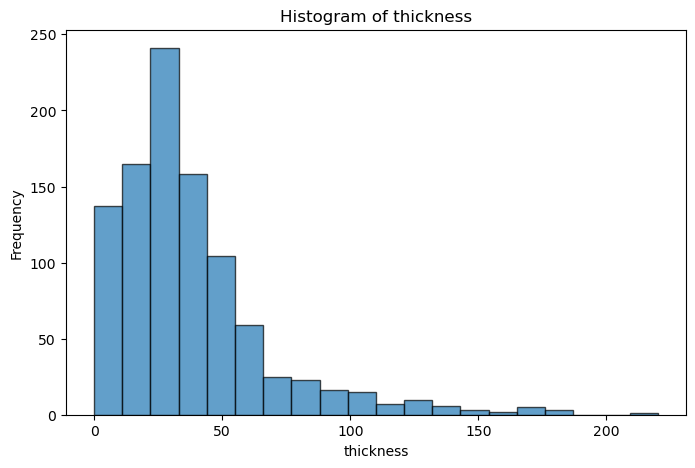

Histogram saved as bark_thickness_main/data_histogram.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = "bark_thickness_main/thickness_data.csv"
df = pd.read_csv(file_path)
print(f"Data points {len(df)}")
# Define the column to process
column_name = "thickness"  # "thickness" column

# Sort the column in ascending order
df_sorted = df.sort_values(by=column_name)

# Export the sorted data to a new CSV file
sorted_file_path = "bark_thickness_main/sorted_thickness_data.csv"
df_sorted.to_csv(sorted_file_path, index=False)
print(f"Sorted data saved as {sorted_file_path}")

# Count zeros in the column
zero_count = (df_sorted[column_name] == 0).sum()
print(f"Number of zeros in '{column_name}':", zero_count)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_sorted[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel(column_name)
plt.ylabel("Frequency")
plt.title(f"Histogram of {column_name}")

# Export histogram as an image
histogram_path = "bark_thickness_main/data_histogram.png"
plt.savefig(histogram_path, dpi=300)
plt.show()

print(f"Histogram saved as {histogram_path}")

## Exploring Lichen Data for Abnormal Estimation

In [13]:
import pandas as pd
import numpy as np

# Load CSV file
file_path = "cleaned_data/updated_lichen_area_dataset_prop_3dec.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# Define the two columns to analyze
column1 = "green_pixels"  # Update with column name
column2 = "white_pixels" 

output_folder = "lichen_data_exploration" 

# Function to analyze a column
def analyze_column(column_name):
    print(f"\n### Analysis for '{column_name}' ###\n")
    
    # Compute IQR
    Q1 = df[column_name].quantile(0.25)  
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Outlier detection thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    print(f"Number of Outliers in '{column_name}': {len(outliers)}")
    print("Outliers:\n", outliers)

    # Get top 15 highest values
    top_15 = df.nlargest(15, column_name)
    print("\nTop 15 Highest Values:\n", top_15)

    # Get 15 lowest values
    bottom_15 = df.nsmallest(15, column_name)
    print("\n15 Lowest Values:\n", bottom_15)

    # Ensure the folder exists (create if not)
    os.makedirs(output_folder, exist_ok=True)
    
    # Save the CSV files in the specified folder
    outliers.to_csv(os.path.join(output_folder, f"outliers_{column_name}.csv"), index=False)
    top_15.to_csv(os.path.join(output_folder, f"top_15_{column_name}.csv"), index=False)
    bottom_15.to_csv(os.path.join(output_folder, f"bottom_15_{column_name}.csv"), index=False)
    
    print(f"Files saved in: {output_folder}")

    print(f"\nResults saved: 'outliers_{column_name}.csv', 'top_15_{column_name}.csv', 'bottom_15_{column_name}.csv'\n")
    print("-" * 50)  # Separator for readability

# Analyze both columns
analyze_column(column1)
analyze_column(column2)


### Analysis for 'green_pixels' ###

Number of Outliers in 'green_pixels': 204
Outliers:
      file_name    ID  top_left_x  top_left_y      area  green_pixels  \
132   P119-610  P119       779.0      1557.0   8027367     1446423.0   
133   P119-611  P119      1128.0      1643.0   8178472     1204368.0   
134   P119-612  P119      1066.0      1549.0   8733457     1313074.0   
135   P119-613  P119       709.0      1491.0   8357261     1523163.0   
141     P12-14   P12      1293.0      1531.0   6722098      843320.0   
...        ...   ...         ...         ...       ...           ...   
2841   S84-257   S84       937.0       858.0   8800372     1220053.0   
2845   S85-987   S85      1076.0       488.0  10398579     1370013.0   
2846   S85-988   S85       430.0       508.0  10659415     1293311.0   
2853    S86-77   S86       934.0       663.0  10286758     1119006.0   
2894   S92-268   S92       462.0       802.0   8698021      829060.0   

      white_pixels  overlap_pixels  green_ex

### Find the Outlier Image Locations

In [20]:
import pandas as pd
import os

# Define the main folder path
main_folder = "D:\internship_images"  # Update with your actual main folder path
target_folder = "lichens"  # Update with the specific folder name to search in
# Load the datasets containing spotted data (outliers, top/bottom 15)
outliers_file = "lichen_data_exploration/outliers_white_pixels.csv"  # Update with actual file name
top_15_file = "lichen_data_exploration/top_15_white_pixels.csv"
bottom_15_file = "lichen_data_exploration/bottom_15_white_pixels.csv"

# Read the CSV files
outliers_df = pd.read_csv(outliers_file)
top_15_df = pd.read_csv(top_15_file)
bottom_15_df = pd.read_csv(bottom_15_file)

# Extract file names from all datasets
file_names = set(outliers_df["file_name"]).union(top_15_df["file_name"], bottom_15_df["file_name"])

# Function to search for images only in the specified target folder
def find_image_paths(main_folder, target_folder, file_names):
    image_paths = []
    for root, dirs, files in os.walk(main_folder):
        if os.path.basename(root) == target_folder:  # Only search inside target folder
            for file in files:
                if file.endswith(".jpg") and file[:-4] in file_names:  # Match file_name with ".png"
                    image_paths.append(os.path.join(root, file))
    return image_paths

# Find image paths in the target folder
image_paths = find_image_paths(main_folder, target_folder, file_names)

# Save image paths to a text file
output_txt = "lichen_data_exploration/white_spotted_image_paths.txt"
with open(output_txt, "w") as f:
    for path in image_paths:
        f.write(path + "\n")

print(f"Found {len(image_paths)} images in '{target_folder}'. Paths saved in '{output_txt}'")

Found 257 images in 'lichens'. Paths saved in 'lichen_data_exploration/white_spotted_image_paths.txt'


## Thickness estimation methods comparisons

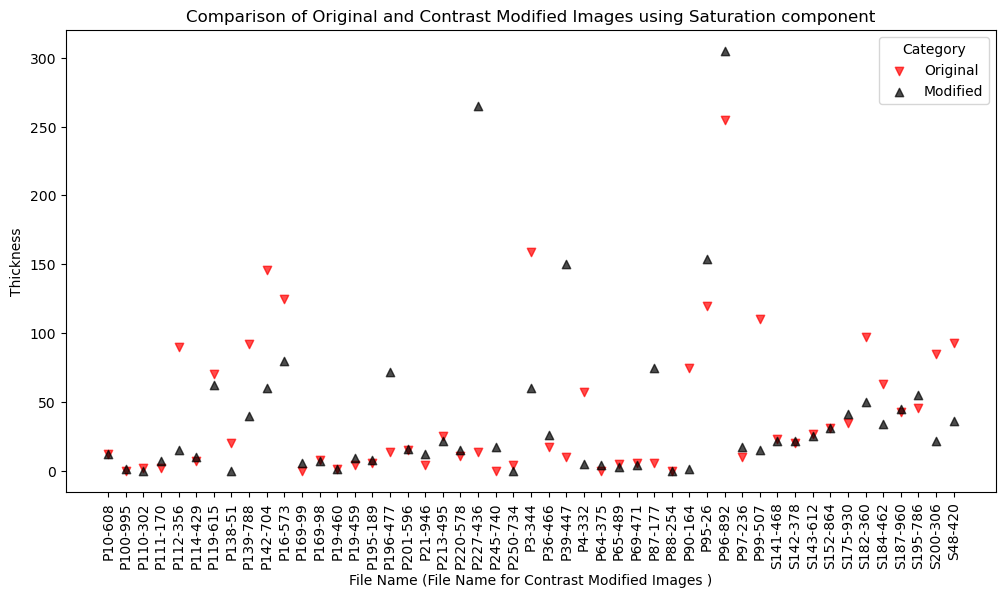

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("bark_thickness/contrast_test_extended_min_S.csv")  # Change this to your actual file path

# Apply dark background style
#plt.style.use("dark_background")

# Create base file name column (removing "_c" for modified entries)
df["base_name"] = df["file_name"].str.replace("_c", "", regex=True)

# Separate original and modified data
df_original = df[~df["file_name"].str.contains("_c")]
df_modified = df[df["file_name"].str.contains("_c")]

# Plot original data
plt.figure(figsize=(12, 6))
plt.scatter(df_original["file_name"], df_original["thickness"], label="Original", color="red", marker="v", alpha=0.7)

# Plot modified data using base file name for X-axis
plt.scatter(df_modified["base_name"], df_modified["thickness"], label="Modified", color="black", marker="^", alpha=0.7)

# Customization
plt.xlabel("File Name (File Name for Contrast Modified Images )")
plt.ylabel("Thickness", color="black")
plt.title("Comparison of Original and Contrast Modified Images using Saturation component", color="black")
plt.xticks(rotation=90, color="black")  # Rotate labels for better visibility
plt.yticks(color="black")
plt.legend(title="Category")

# Save the figure
plt.savefig("bark_thickness/contrast_test_min_S.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


## Plots for Bark thickness Section

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hsv
import numpy.polynomial.polynomial as poly

def compute_bark_thickness(image_path, save_dir):
    """Computes bark thickness and saves multiple plots including overlay on transformed image."""
    image = imread(image_path)
    rgb_image = image[..., :3]
    mask = (image[..., 3] > 0).astype(np.uint8) * 255  # Alpha channel as mask
    
    hsv_image = rgb2hsv(rgb_image)
    """Select appropriate component to be used in computation Saturation or Value."""
    #component = hsv_image[..., 1] # Saturation
    component = hsv_image[..., 2] # Value

    value_matrix = -1 * np.ones((3601, 629))
    center_x, center_y = image.shape[0] / 2, image.shape[1] / 2
    
    idx = 0
    for angle in np.arange(0, 2 * np.pi, 0.01):
        value_vector = return_component_along_radius(component, mask, angle, center_x, center_y)
        value_vector = value_vector[::-1]

        i = 0
        while i < len(value_vector) and value_vector[i] == -1:
            i += 1

        value_vector = value_vector[i:]
        value_matrix[:len(value_vector), idx] = value_vector
        idx += 1

    value_matrix[value_matrix == -1] = np.nan
    median_curve = np.nanmedian(value_matrix, axis=1)

    ###### For plotting image state before inversion
    raw_value_matrix = -1 * np.ones((3601, 629))
    idx = 0
    for angle in np.arange(0, 2 * np.pi, 0.01):
        value_vector = return_component_along_radius(component, mask, angle, center_x, center_y)
    
        i = 0
        while i < len(value_vector) and value_vector[i] == -1:
            i += 1
    
        value_vector_cleaned = value_vector[i:]
        raw_value_matrix[:len(value_vector_cleaned), idx] = value_vector_cleaned
        idx += 1

    
    # Compute derivative analysis
    thickness_ranges = np.arange(20, 306, 5)
    table_of_derivatives = np.zeros((500, len(thickness_ranges)))
    
    for i, t_range in enumerate(thickness_ranges):
        x = np.arange(1, t_range + 1)
        poly_fit = poly.Polynomial.fit(x, median_curve[:t_range], 5)
        derivative_values = poly_fit.deriv()(x)
        table_of_derivatives[:len(derivative_values), i] = derivative_values
    
    smoothed_mean_derivative = np.convolve(np.nanmean(table_of_derivatives, axis=1), np.ones(5)/5, mode='valid')
    
    """Use variables below if using Satuation component of HSV."""
    #thickness = np.argmin(smoothed_mean_derivative)
    #peak_derivative_value = np.min(smoothed_mean_derivative)
    
    """Use variables below if using Value component of HSV."""
    thickness = np.argmax(smoothed_mean_derivative)
    peak_derivative_value = np.max(smoothed_mean_derivative)


    ### Fitted Polynomials Plot ###
    plt.figure(figsize=(8, 5))
    x = np.arange(len(median_curve))
    plt.plot(median_curve, label='Median Curve', color='blue', alpha=0.4)
    
    for degree in [3, 5, 7]:
        fit = poly.Polynomial.fit(x[:300], median_curve[:300], degree)
        plt.plot(x[:300], fit(x[:300]), label=f'Degree {degree} Fit')
    
    plt.axvline(x=thickness, color='red', linestyle='--', label=f"Estimated Thickness ({thickness})")
    plt.xlabel("Distance from outer edge")
    plt.ylabel("Component Value")
    plt.title("Polynomial Fits to Median Curve")
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    
    polyfit_plot_path = os.path.join(save_dir, f"{os.path.basename(image_path).replace('.png', '')}_polyfit_curve.png")
    plt.savefig(polyfit_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    ### Pixel Sampling (Before Flip) ###
    plt.figure(figsize=(10, 5))
    plt.imshow(raw_value_matrix.T, cmap='gray', interpolation='nearest', aspect='auto', origin='upper')
    plt.title(f"Radial Sampling (Uninverted) – {os.path.basename(image_path)}")
    #plt.xlabel("Distance from Center (pixels)")
    #plt.ylabel("Angle Index")
    
    # Limit x-axis to 1600
    plt.xlim(0, 1100)
     
    raw_sampling_path = os.path.join(save_dir, f"{os.path.basename(image_path).replace('.png', '')}_radial_sampling_unflipped.png")
    plt.savefig(raw_sampling_path, dpi=300, bbox_inches="tight")
    plt.close()


    ### Overlay Mask Center on Original Image ###
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgb_image)
    ax.scatter(center_y, center_x, color='red', s=40, label='Center')  # note: (x, y) reversed in scatter
    ax.set_title(f"Mask Center on Original Image – {os.path.basename(image_path)}")
    ax.axis('off')
    ax.legend()
    
    center_overlay_path = os.path.join(save_dir, f"{os.path.basename(image_path).replace('.png', '')}_mask_center_overlay.png")
    plt.savefig(center_overlay_path, dpi=300, bbox_inches="tight")
    plt.close()

    
    ### Save Median Curve Plot ###
    plt.figure(figsize=(8, 5))
    plt.plot(median_curve, color="blue", linestyle="dashed", label="Median Curve", alpha=0.6)
    plt.axvline(x=thickness, color='red', linestyle='--', label=f'Thickness ({thickness})') ##########################
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Median over radii (HSV Value)", fontsize=14)
    plt.title(f"Median Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)

    median_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_median_curve.png"
    median_plot_path = os.path.join(save_dir, median_plot_filename)
    plt.savefig(median_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    ### Save Smoothed Derivative Curve ###
    plt.figure(figsize=(8, 5))
    plt.plot(smoothed_mean_derivative, linewidth=2, color='red', label='Smoothed Mean Derivative')
    plt.axvline(x=thickness, color='blue', linestyle='--', label=f'Thickness ({thickness})')
    plt.xlabel("Distance from outer edge of bark", fontsize=14)
    plt.ylabel("Smoothed Mean Derivative", fontsize=14)
    plt.title(f"Smoothed Derivative Curve for {os.path.basename(image_path)}", fontsize=16)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.6)

    derivative_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_derivative_curve.png"
    derivative_plot_path = os.path.join(save_dir, derivative_plot_filename)
    plt.savefig(derivative_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    ### Save Overlay of Thickness Estimate on Transformed Image ###
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot the transformed bark image (without exporting it separately)
    ax1.imshow(value_matrix.T, cmap="gray", interpolation="nearest", aspect='auto')
    ax1.set_title(f"Transformed Image with Estimated Thickness ({os.path.basename(image_path)})")
    #ax1.set_xlabel("Angle Index")
    #ax1.set_ylabel("Distance from Outer Edge")
    ax1.set_xlim([0, 1100])  # Ensuring proper scaling

    # Overlay only the estimated thickness line
    ax1.axvline(x=thickness, color='red', linestyle='--', linewidth=2, label=f"Estimated Thickness ({thickness})")
    ax1.legend(loc="upper left")

    # Save the overlay plot
    overlay_plot_filename = f"{os.path.basename(image_path).replace('.png', '')}_overlay_transformed.png"
    overlay_plot_path = os.path.join(save_dir, overlay_plot_filename)
    plt.savefig(overlay_plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    return thickness, peak_derivative_value, os.path.basename(image_path), median_plot_path, derivative_plot_path, overlay_plot_path

def return_component_along_radius(component, mask, angle, center_x, center_y):
    width, height = component.shape
    longest_radius = int(np.floor(np.sqrt(width**2 + height**2) / 2))
    component_vector = -1 * np.ones(longest_radius + 1)

    for r in range(longest_radius + 1):
        x = int(center_x + r * np.cos(angle))
        y = int(center_y + r * np.sin(angle))

        if 0 <= x < width and 0 <= y < height:
            if mask[x, y] == 255:
                component_vector[r] = component[x, y]
    
    return component_vector

def extract_id(filename):
    match = re.match(r"([A-Za-z0-9]+)-", filename)
    return match.group(1) if match else "Unknown"

def process_folder(input_folder, output_csv):
    print("📂 Starting bark thickness analysis...")  # Start message
    results_by_id = {}

    for subdir, _, files in os.walk(input_folder):
        if os.path.basename(subdir) != "ends":  
            continue  # Skip folders that are not the target folder

        png_files = [f for f in files if f.endswith(".png")]
        if not png_files:
            continue  # Skip if no PNG files are found in the target folder

        parent_folder = os.path.dirname(subdir)  # Get the parent folder of 'target'
        plot_folder = os.path.join(parent_folder, "plots")  # Save plots in the parent folder
        os.makedirs(plot_folder, exist_ok=True)

        print(f"\n🎯 Processing target folder: {subdir} ({len(png_files)} images)")

        for filename in png_files:
            image_path = os.path.join(subdir, filename)
            print(f"  📷 Processing image: {filename}...")

            try:
                thickness, peak_derivative_value, image_name, median_plot_path, derivative_plot_path, overlay_plot_path = compute_bark_thickness(image_path, plot_folder)

                if thickness is not None:
                    image_id = extract_id(filename)
                    if image_id not in results_by_id:
                        results_by_id[image_id] = []
                    results_by_id[image_id].append((image_name, thickness))
                    
                    print(f"    ✅ Thickness computed: {thickness} (Saved to {plot_folder})")
                else:
                    print(f"    ⚠️ Skipping {filename} (No valid thickness found)")

            except Exception as e:
                print(f"    ❌ Error processing {filename}: {e}")

    # Sort results by thickness
    for image_id in results_by_id:
        results_by_id[image_id].sort(key=lambda x: x[1])

    # Write results to CSV
    print("\n💾 Saving results to CSV...")
    write_header = not os.path.exists(output_csv) or os.stat(output_csv).st_size == 0  # Check if file is new or empty

    with open(output_csv, "a") as f:
        if write_header:
            f.write("ID,file_name,thickness\n")  # Write header only once
    
        for image_id, images in results_by_id.items():
            for image_name, thickness in images:
                f.write(f"{image_id},{image_name.replace('.png', '')},{thickness}\n")

input_folder = 'bark_thickness/thesis_plots'
output_csv = "bark_thickness/thesis_plots/thesis_plot_max_v.csv"

# Process the folder
process_folder(input_folder, output_csv)

## Merge Bark Thickness Test Data

In [4]:
import pandas as pd

# Load both datasets
df1 = pd.read_csv('bark_thickness/contrast_test_extended_min_S.csv')  # Main dataset
df2 = pd.read_csv('bark_thickness/contrast_test_extended_max_V.csv')  # Contains file_name and max_V

# Drop duplicates or group by to ensure one max_V per file_name
# Option 1: If duplicates are identical and safe to drop
df2_unique = df2[['file_name', 'max_V']].drop_duplicates(subset='file_name')

# Option 2: If file_name has multiple max_V values, keep the highest
# df2_unique = df2.groupby('file_name', as_index=False)['max_V'].max()

# Merge only on unique file_name values
merged_df = pd.merge(df1, df2_unique, on='file_name', how='inner')

# Save the result
merged_df.to_csv('bark_thickness/merged_thickness_test_dataset.csv', index=False)


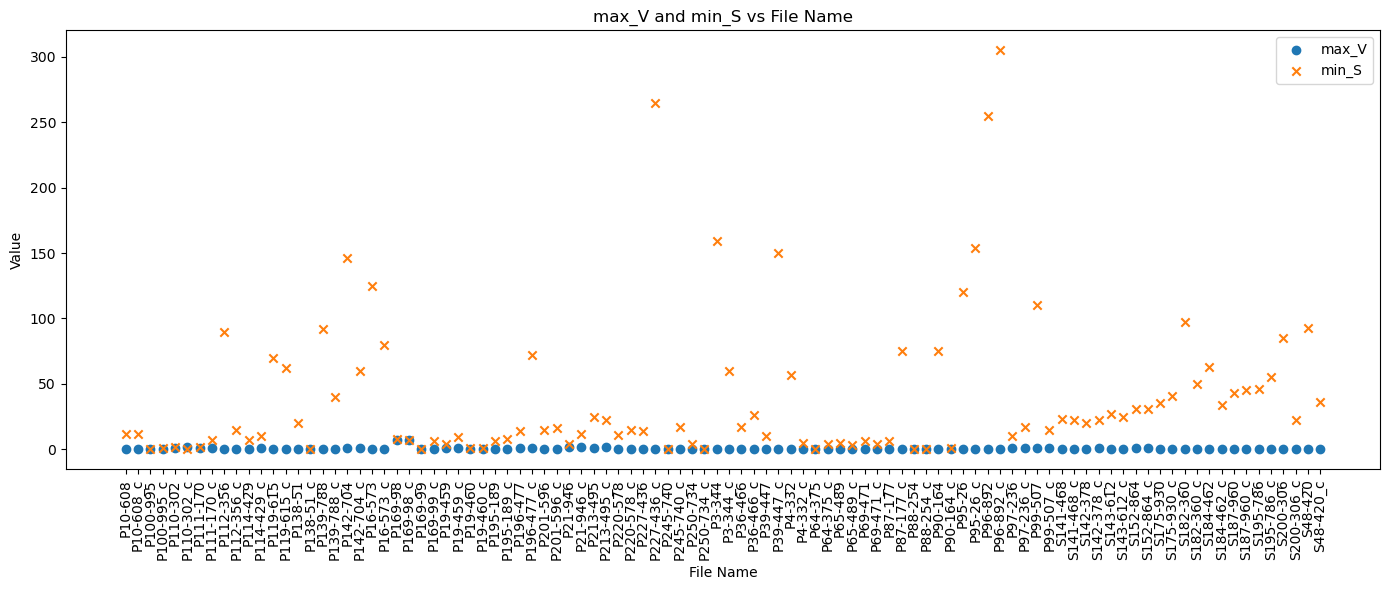

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
df = pd.read_csv('bark_thickness/merged_thickness_test_dataset.csv')

# Sort by file_name if needed
df = df.sort_values(by='file_name')

# Set figure size
plt.figure(figsize=(14, 6))

# Plot max_V
plt.scatter(df['file_name'], df['max_V'], label='max_V', marker='o')

# Plot min_S
plt.scatter(df['file_name'], df['min_S'], label='min_S', marker='x')

# Rotate x labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('File Name')
plt.ylabel('Value')
plt.title('max_V and min_S vs File Name')
plt.legend()
plt.tight_layout()

# Show plot
plt.show()